# Outlier Detection
- Angie Hu

- 05/13/2019

# Problem Statement:

Understanding time series data is fundamental to our ability to generate insights for our customers. For this challenge, we have provided a set of time series data each with a label for whether we consider it "noisy", i.e., highly irregular, volatile, and prone to spurious anomalies.


In the provided gzipped tar archive ( outlier-challenge.tar.gz ), you will find two CSV files: 
- challenge-labels.csv
- challenge-data.csv

As stated above, please perform an exploratory data analysis and build a classifier for this problem. Please feel free to:
- use any methods and tools that you choose
- state and make any reasonable assumptions
v ask relevant, clarifying questions

# Summary of findings:

<div style=' background-color: #edc7d9; border-color: #edc7d9;
border-left: 5px solid #edc7d9; padding: 0.5em; margin-top: 1em;'>

### 1. Data Exploration:
   - No significant class imbanlance (should not be a problem)
   - Noisy and non-noisy time series look different visually

   
### 2. Aggregation and Feature Engineering:
   - ``Group by`` ids and calculate basic ``descriptive stats`` for each id to create features
   - Measurements of variability of the data are important
   - Derive relative stats: normalize by the mean (e.g. normalized range)
   - Create number of ``outliers`` features based on different criterias
   - Noisy examples: higher coefficient of variation, more skewed, have more zeros and outliers
 
### 3. Build Models:
   - Some features are highly correlated
   - Decision tree does a decent job
   - ``Random forest`` performs better
   - In general, the features that measure the ``variability`` of the data are more important

### 4. More Feature Engineering:
   - New feature: starts in september or not
   - Create a feature: ``stationary`` or not base on Augmented Dickey-Fuller test
   - Add features that meatures ``autocorrelations``
   - Add another feature: ``number of peaks``
   
### 5. Build The Final Model:
   - Compare the performance of a few classifiers: random forest seems to perform the best
   - Hyperparameter tuning
   - Compare the perfomance of RF and logistic regression using ROC curves
   - Assuming we care more about identifying the noisy examples, choose the thresholds: 
        - a ``Recall`` of 81% can be achieved if we accept a ``False Positive Rate`` of ~20% .
        - a ``Recall`` of 85% can be achieved if we accept a ``False Positive Rate`` of ~25% .
   - ``Autocorrelations``, ``Number of zeros``, and ``normalized inter quartile range`` are the top 3 important features

# 1. Data Exploration
### Set up

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pandas_profiling

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
warnings.simplefilter('ignore')

In [2]:
data = pd.read_csv('challenge-data.csv')

In [3]:
data['Date'] = pd.to_datetime(data['date'])

In [1]:
# pandas_profiling.ProfileReport(data)

## Mean value for each id: most are small, with some large examples

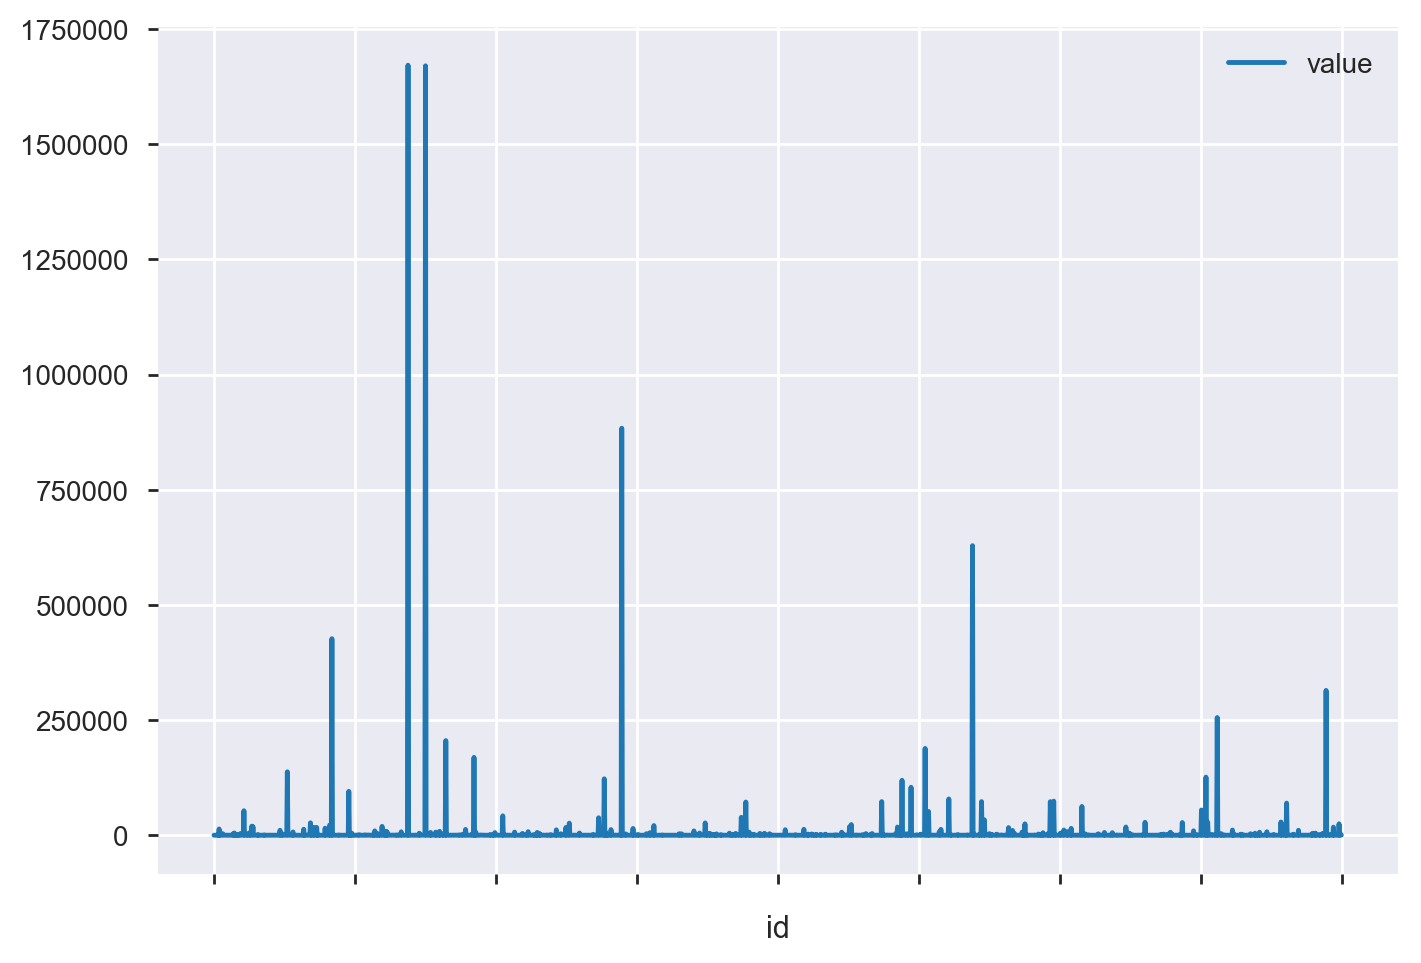

In [5]:
data.groupby(data.id).agg({'value':'mean'}).plot()

In [6]:
labels = pd.read_csv('challenge-labels.csv')

## 2000 unique ids and labels: 
### Features can be generated by aggregating challenge-data.csv (91 entries per id)
### No significant class imbalance

In [7]:
pandas_profiling.ProfileReport(labels)

Number of variables,2
Number of observations,2000
Total Missing (%),0.0%
Total size in memory,17.7 KiB
Average record size in memory,9.0 B
Numeric,0
Categorical,0
Boolean,1
Date,0
Text (Unique),1
Rejected,0


In [8]:
data.groupby(data.id).agg({'value':'mean'}).head()

,value
id,
id-00000,46.429064
id-00001,0.956044
id-00002,0.307692
id-00003,0.219780
id-00004,1.109890


In [9]:
true_ids = ['00','12','24','46','55','95']
false_ids = ['07','15','22','37','45','59']

In [10]:
# define a plt function
def all_plots(num_rows,num_cols,num_plots,ids):
    fig = plt.figure()
    fig.set_figheight(5)
    fig.set_figwidth(15)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i in range(num_plots):
        plt.subplot(num_rows, num_cols, i+1)
        ax = data.loc[data.id == 'id-000'+ ids[i] ].value.plot()
#         plt.plot(data.loc[data.id == 'id-000'+ ids[i]].Date, data.loc[data.id == 'id-000'+ ids[i]].value)
        ax.legend(['id_000'+ids[i]])

# Examples of noisy and non-noisy time series
### In general, the noisy data have larger varibility (relatively) and more extreme values
### Also we can see that the noisy data have relatively smaller values

### Noisy

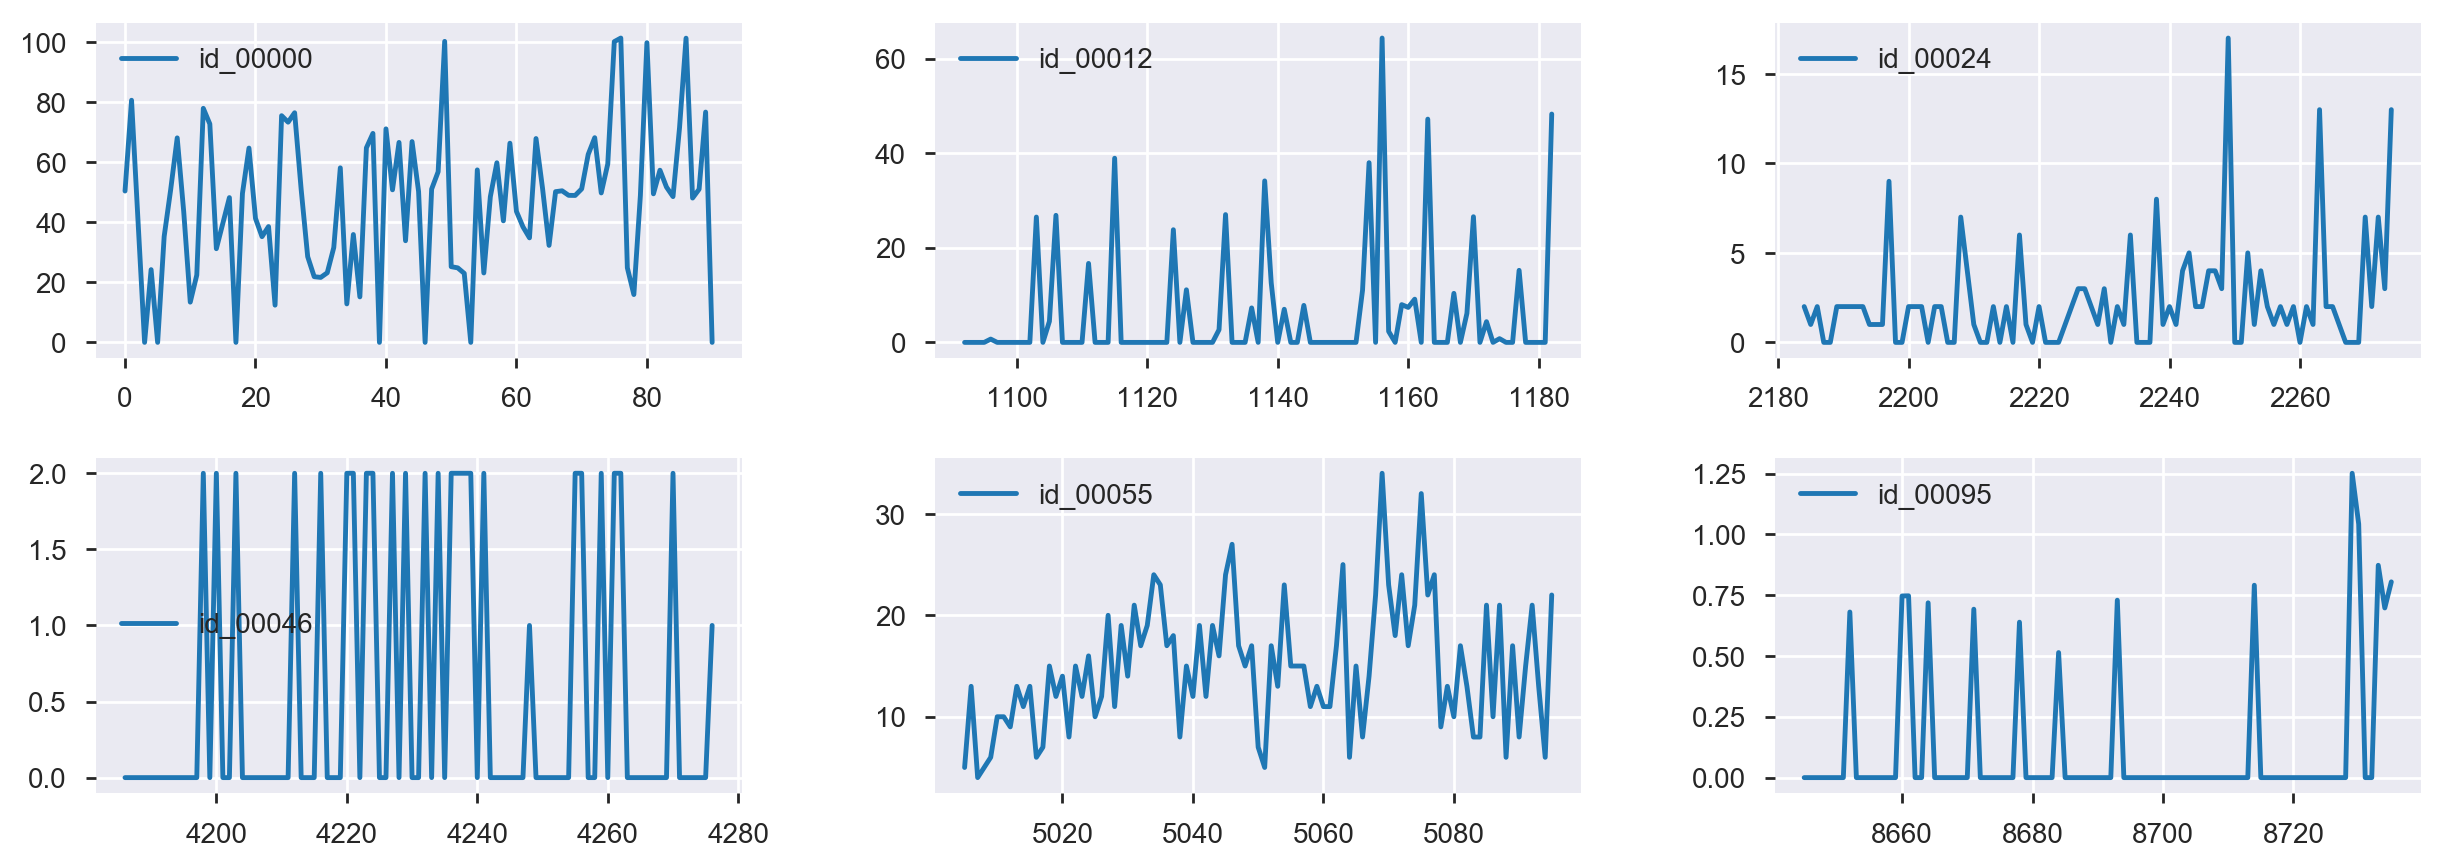

In [11]:
all_plots(2,3,6,true_ids)

### Non-noisy

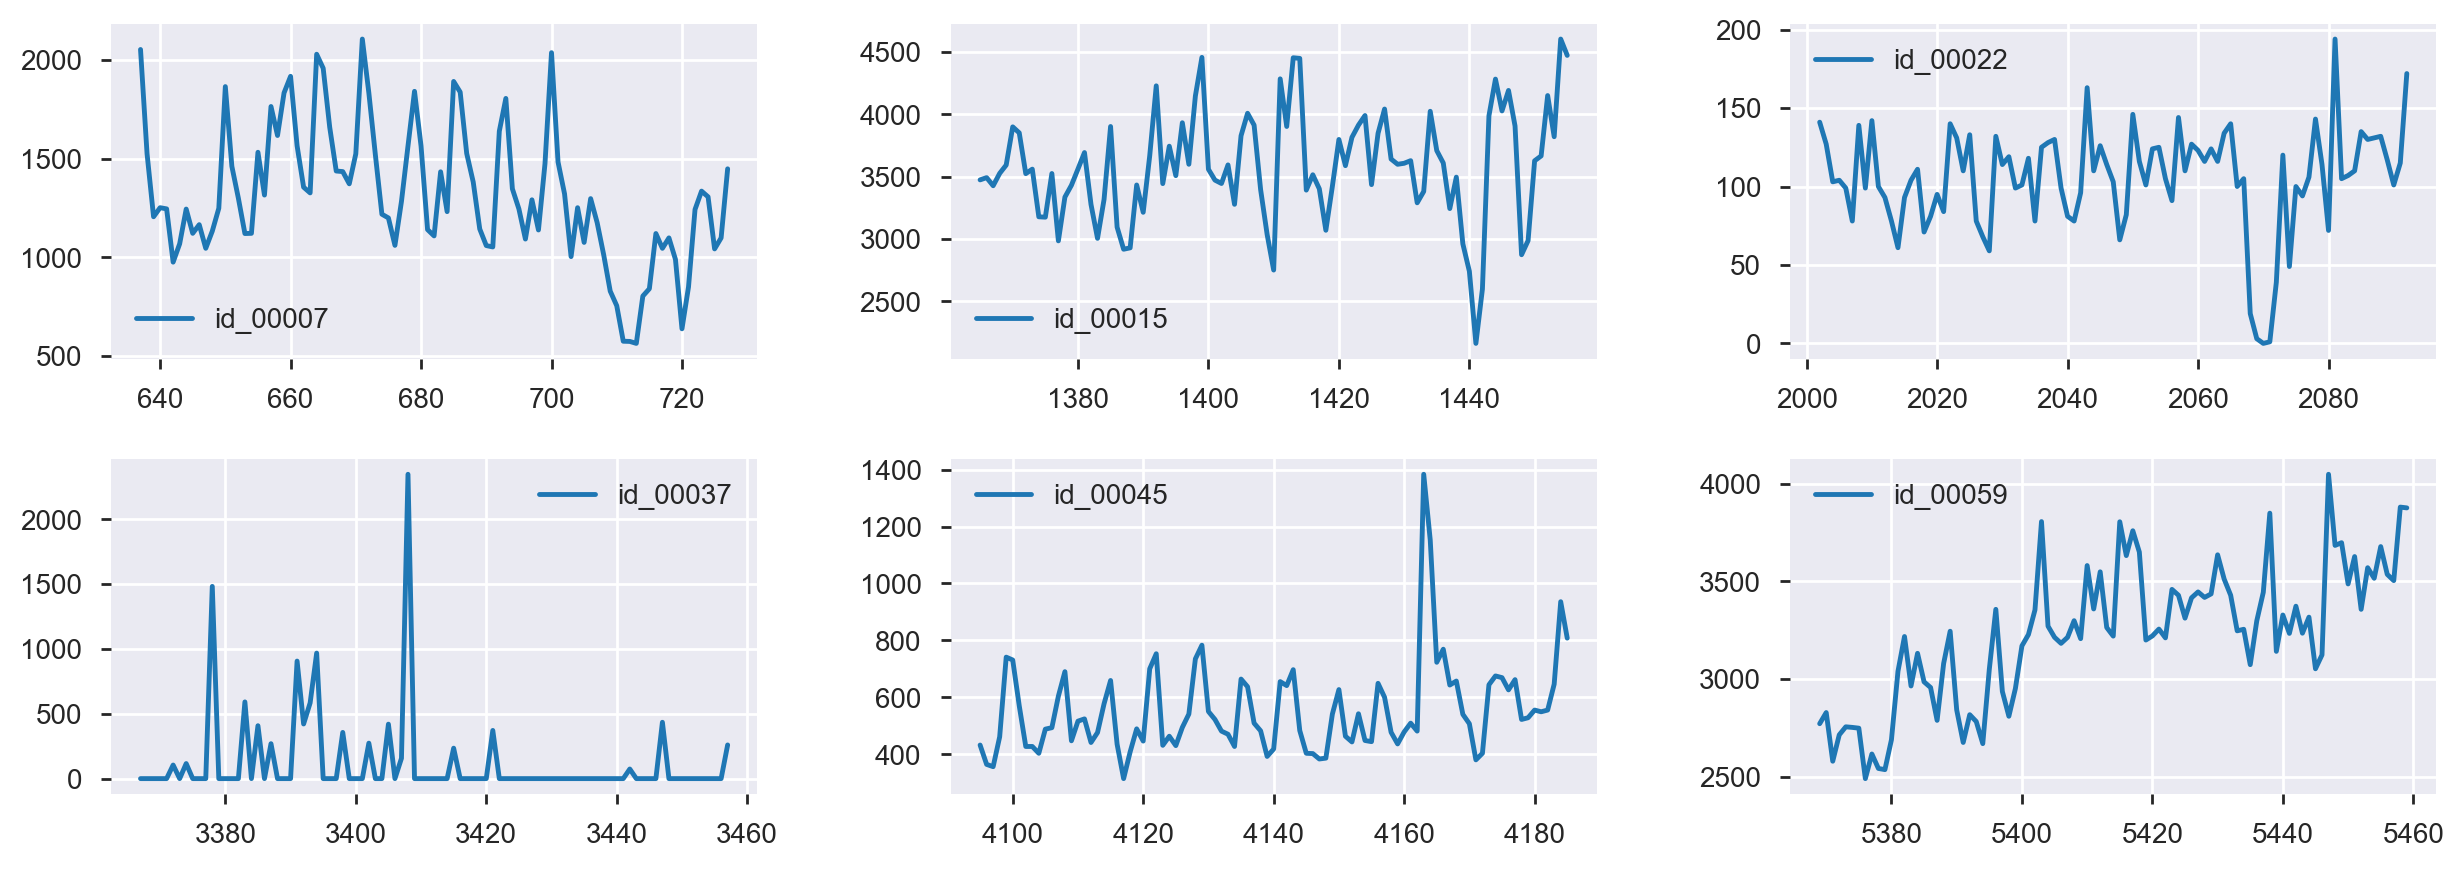

In [12]:
all_plots(2,3,6,false_ids)

# 2. Aggregation and Feature Engineering

## Define different outlier criterias

In [13]:
def get_num1_outliers (column):
    lower = column.mean() - 2*column.std()
    upper = column.mean() + 2*column.std()
    return sum((column < lower) | (column > upper))

In [14]:
def get_num2_outliers (column):
    q1 = np.percentile(column, 25)
    q3 = np.percentile(column, 75)
    IQR = q3 - q1
    return sum((column < (q1 - 1.5 * IQR)) | (column > (q3 + 1.5 * IQR)))

In [15]:
def get_num3_outliers (column):
    q1 = np.percentile(column, 25)
    q3 = np.percentile(column, 75)
    IQR = q3 - q1
    return sum((column < (q1 - 2.5 * IQR)) | (column > (q3 + 2.5 * IQR)))

In [16]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

## Aggregation functions, group by id

In [17]:
# aggregation = {'value':{'mean_val':'mean', 'min_val': 'min', 'max_val':'max',
#                         'median_val': 'median', 'range': lambda x: max(x)-min(x),
#                         'IQ_range1_relative':lambda x: (np.percentile(x, 75)-np.percentile(x, 25))/(max(x)-min(x)),
#                         'IQ_range2_relative':lambda x: (np.percentile(x, 95)-np.percentile(x, 5))/(max(x)-min(x)),
                        
# #                         '95_per' : lambda x: (np.percentile(x, 50)- np.median(x))/np.mean(x), 
# #                         '5_per' : percentile(5),'95_per' : percentile(95),
#                         'std_val':'std', 'coef_of_variation_val': lambda x: np.std(x)/np.mean(x),
#                         'skew_val':'skew', 'num1_outliers': get_num1_outliers,
#                         'num2_outliers': get_num2_outliers,'num3_outliers': get_num3_outliers}}

In [18]:
aggregation = {'value':{'mean_val':'mean', 'min_val': 'min', 'max_val':'max',
                        'median_val': 'median',
                        'range': lambda x: max(x)-min(x),
                        'min_relative': lambda x: min(x)/np.mean(x), 
                        'max_relative': lambda x: max(x)/np.mean(x),
                        'median_relative': lambda x: np.median(x)/np.mean(x),
                        'range_relative': lambda x: max(x)-min(x)/np.mean(x),
                        'IQ_range1_relative':lambda x: (np.percentile(x, 75)-np.percentile(x, 25))/(max(x)-min(x)),
                        'IQ_range2_relative':lambda x: (np.percentile(x, 95)-np.percentile(x, 5))/(max(x)-min(x)),
                        
#                         '95_per' : lambda x: (np.percentile(x, 50)- np.median(x))/np.mean(x), 
#                         '5_per' : percentile(5),'95_per' : percentile(95),
                        'std_val':'std', 
                        'coef_of_variation_val': lambda x: np.std(x)/np.mean(x),
                        'skew_val':'skew', 
                        'num1_outliers': get_num1_outliers,
                        'num2_outliers': get_num2_outliers,
                        'num3_outliers': get_num3_outliers}}

In [19]:
grouped = data.groupby(data.id).agg(aggregation)

In [20]:
grouped.columns = grouped.columns.droplevel(level=0)
grouped = grouped.reset_index()
grouped = grouped.drop('id',axis = 1)

In [21]:
grouped.head()

,mean_val,min_val,max_val,median_val,range,min_relative,max_relative,median_relative,range_relative,IQ_range1_relative,IQ_range2_relative,std_val,coef_of_variation_val,skew_val,num1_outliers,num2_outliers,num3_outliers
0,46.429064,0.0,101.43895,49.014999,101.43895,0.0,2.184816,1.055696,101.43895,0.333217,0.890228,24.733014,0.529770,0.071467,5.0,0.0,0.0
1,0.956044,0.0,12.00000,0.000000,12.00000,0.0,12.551724,0.000000,12.00000,0.125000,0.416667,1.993947,2.074131,3.122942,6.0,6.0,4.0
2,0.307692,0.0,2.00000,0.000000,2.00000,0.0,6.500000,0.000000,2.00000,0.000000,1.000000,0.710122,2.295181,1.949716,13.0,15.0,15.0
3,0.219780,0.0,2.00000,0.000000,2.00000,0.0,9.100000,0.000000,2.00000,0.000000,1.000000,0.611050,2.764959,2.533387,9.0,11.0,11.0
4,1.109890,0.0,5.00000,1.000000,5.00000,0.0,4.504950,0.900990,5.00000,0.400000,0.600000,1.224296,1.097001,0.751607,3.0,0.0,0.0


In [22]:
df = pd.concat([labels, grouped], axis=1)

In [23]:
df['kurt_val'] = 0
df['kurt_val'][:] = data.groupby(data.id).apply(pd.DataFrame.kurt).value[:]

## Count the number of zeros for each id

In [24]:
df['num_zeros'] = 0
df['num_zeros'][:] = data.groupby(data.id).apply(lambda x: x.loc[data.value == 0].value.count())[:]

In [25]:
df.head()

,id,label,mean_val,min_val,max_val,median_val,range,min_relative,max_relative,median_relative,...,IQ_range1_relative,IQ_range2_relative,std_val,coef_of_variation_val,skew_val,num1_outliers,num2_outliers,num3_outliers,kurt_val,num_zeros
0,id-00000,True,46.429064,0.0,101.43895,49.014999,101.43895,0.0,2.184816,1.055696,...,0.333217,0.890228,24.733014,0.529770,0.071467,5.0,0.0,0.0,-0.149305,7
1,id-00001,True,0.956044,0.0,12.00000,0.000000,12.00000,0.0,12.551724,0.000000,...,0.125000,0.416667,1.993947,2.074131,3.122942,6.0,6.0,4.0,11.931713,63
2,id-00002,True,0.307692,0.0,2.00000,0.000000,2.00000,0.0,6.500000,0.000000,...,0.000000,1.000000,0.710122,2.295181,1.949716,13.0,15.0,15.0,1.930770,76
3,id-00003,True,0.219780,0.0,2.00000,0.000000,2.00000,0.0,9.100000,0.000000,...,0.000000,1.000000,0.611050,2.764959,2.533387,9.0,11.0,11.0,4.677329,80
4,id-00004,True,1.109890,0.0,5.00000,1.000000,5.00000,0.0,4.504950,0.900990,...,0.400000,0.600000,1.224296,1.097001,0.751607,3.0,0.0,0.0,-0.180031,43


## The noisy examples have higher coefficient of variation and higher skewness

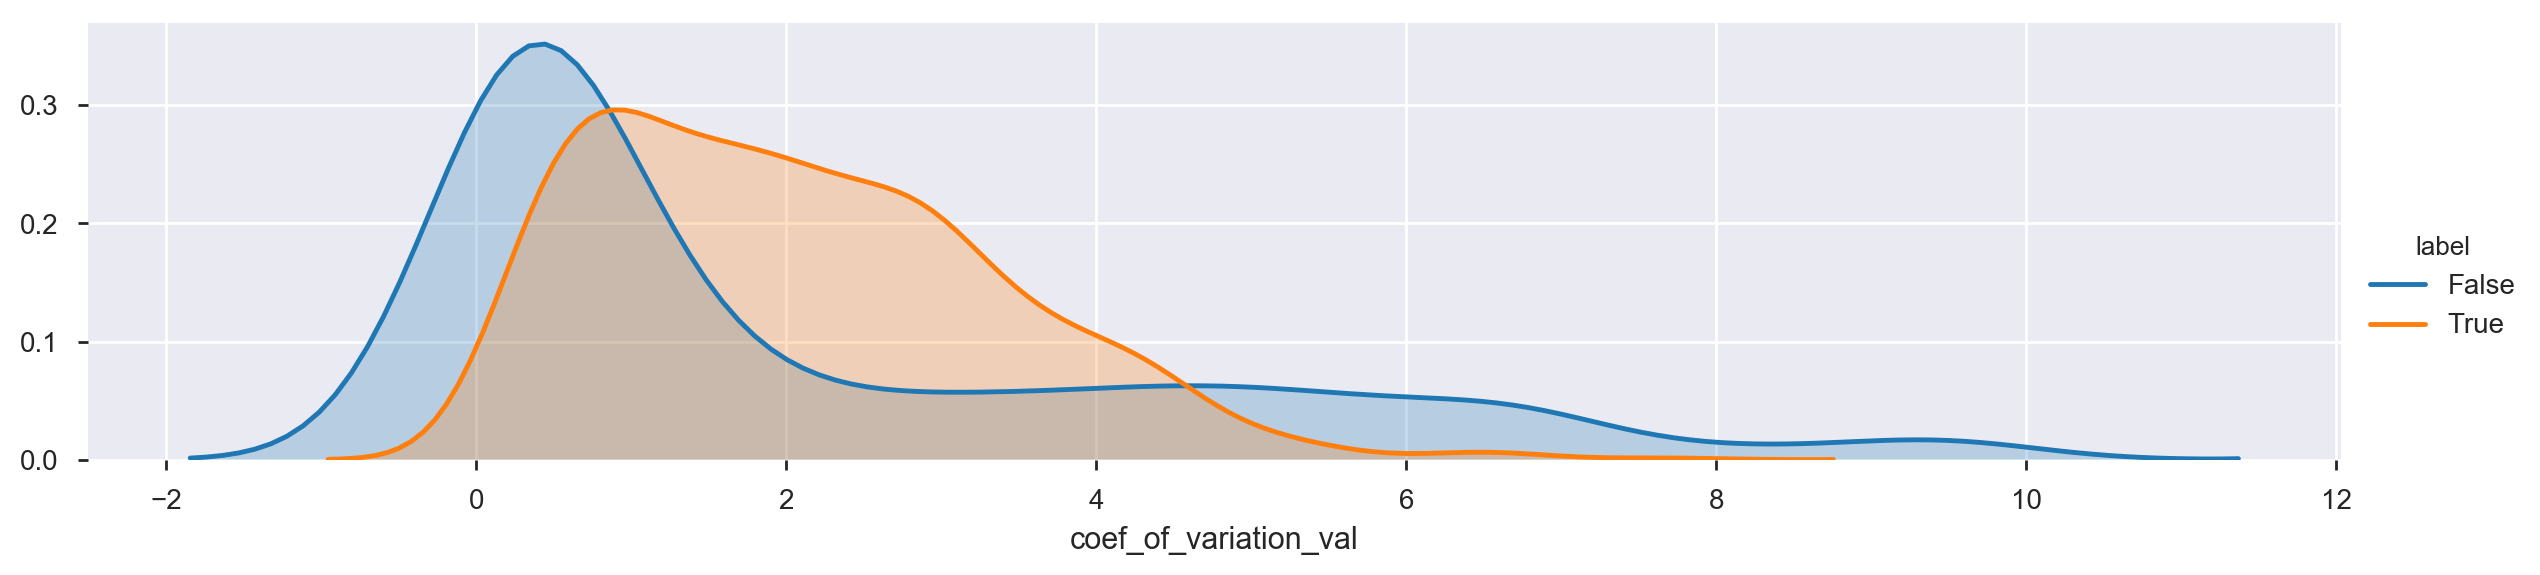

In [26]:
a = sns.FacetGrid(df, hue = 'label', aspect=4 )
a.map(sns.kdeplot, 'coef_of_variation_val', shade= True )
# a.set(xlim=(0 , 200))
a.add_legend()

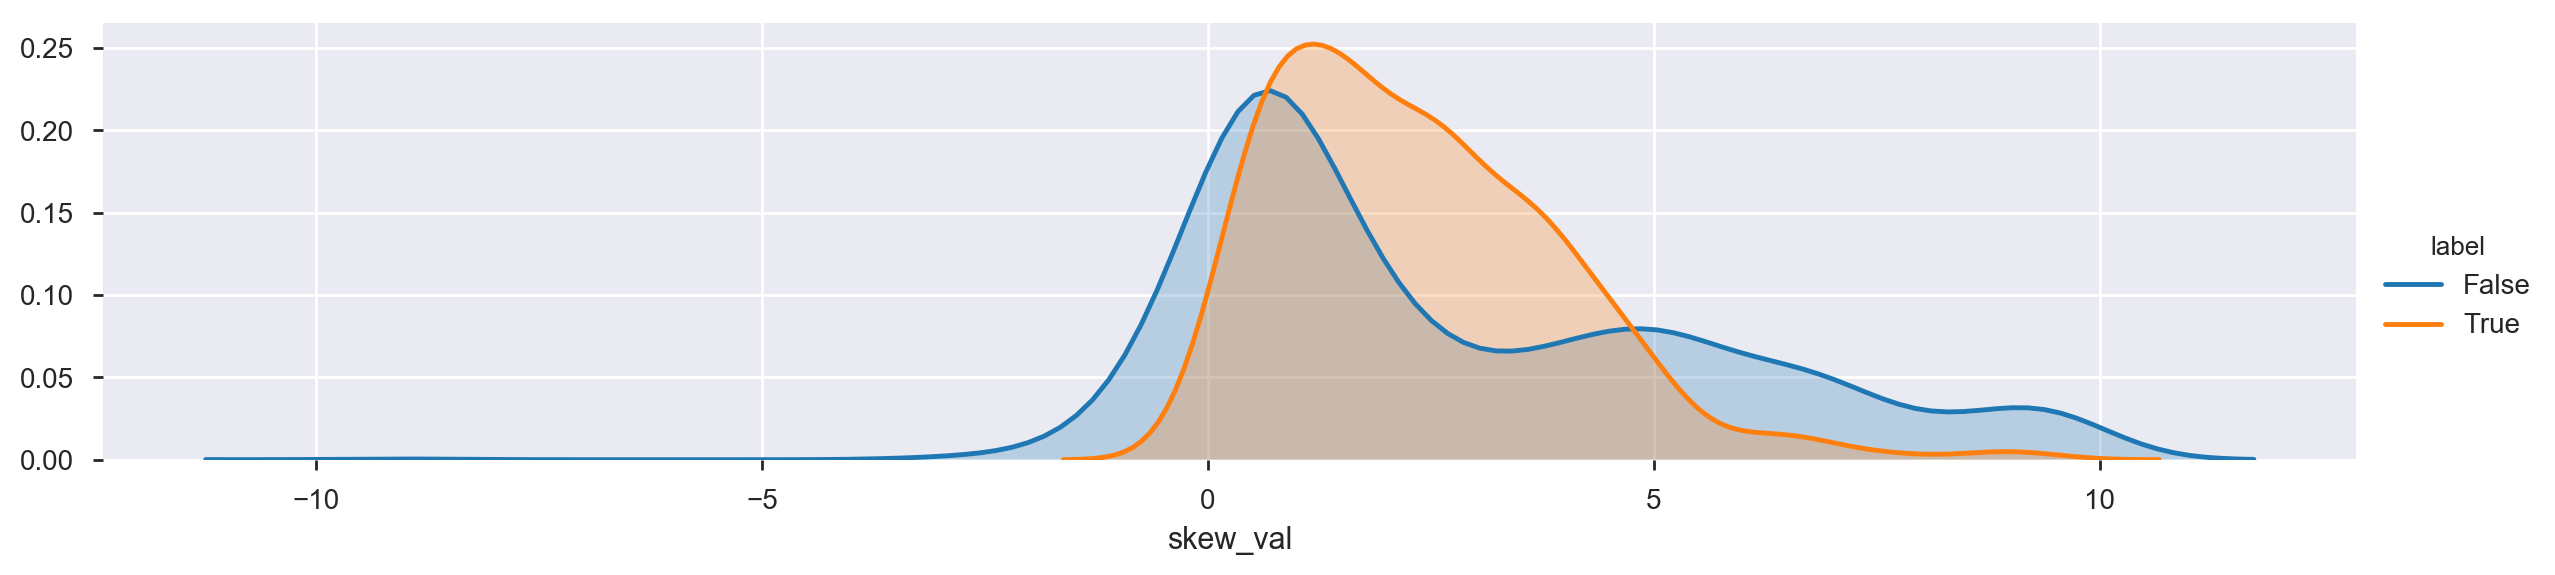

In [27]:
a = sns.FacetGrid(df, hue = 'label', aspect=4 )
a.map(sns.kdeplot, 'skew_val', shade= True )
# a.set(xlim=(0 , 200))
a.add_legend()

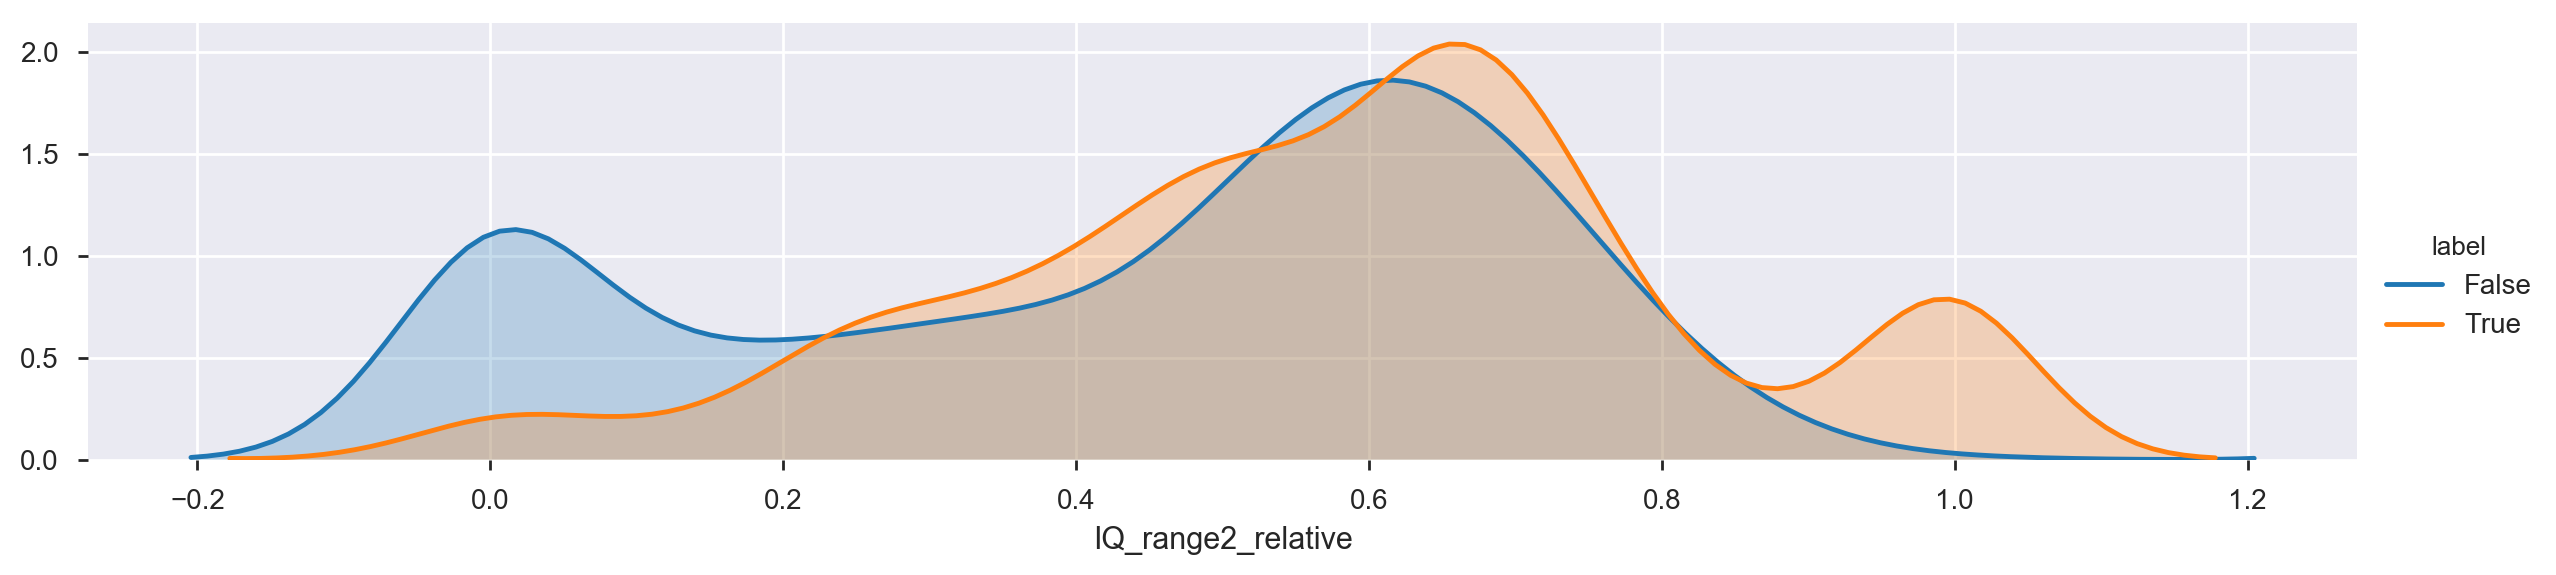

In [28]:
a = sns.FacetGrid(df, hue = 'label', aspect=4 )
a.map(sns.kdeplot, 'IQ_range2_relative', shade= True )
# a.set(xlim=(0 , 200))
a.add_legend()

## Noisy examples are likely to have more zeros

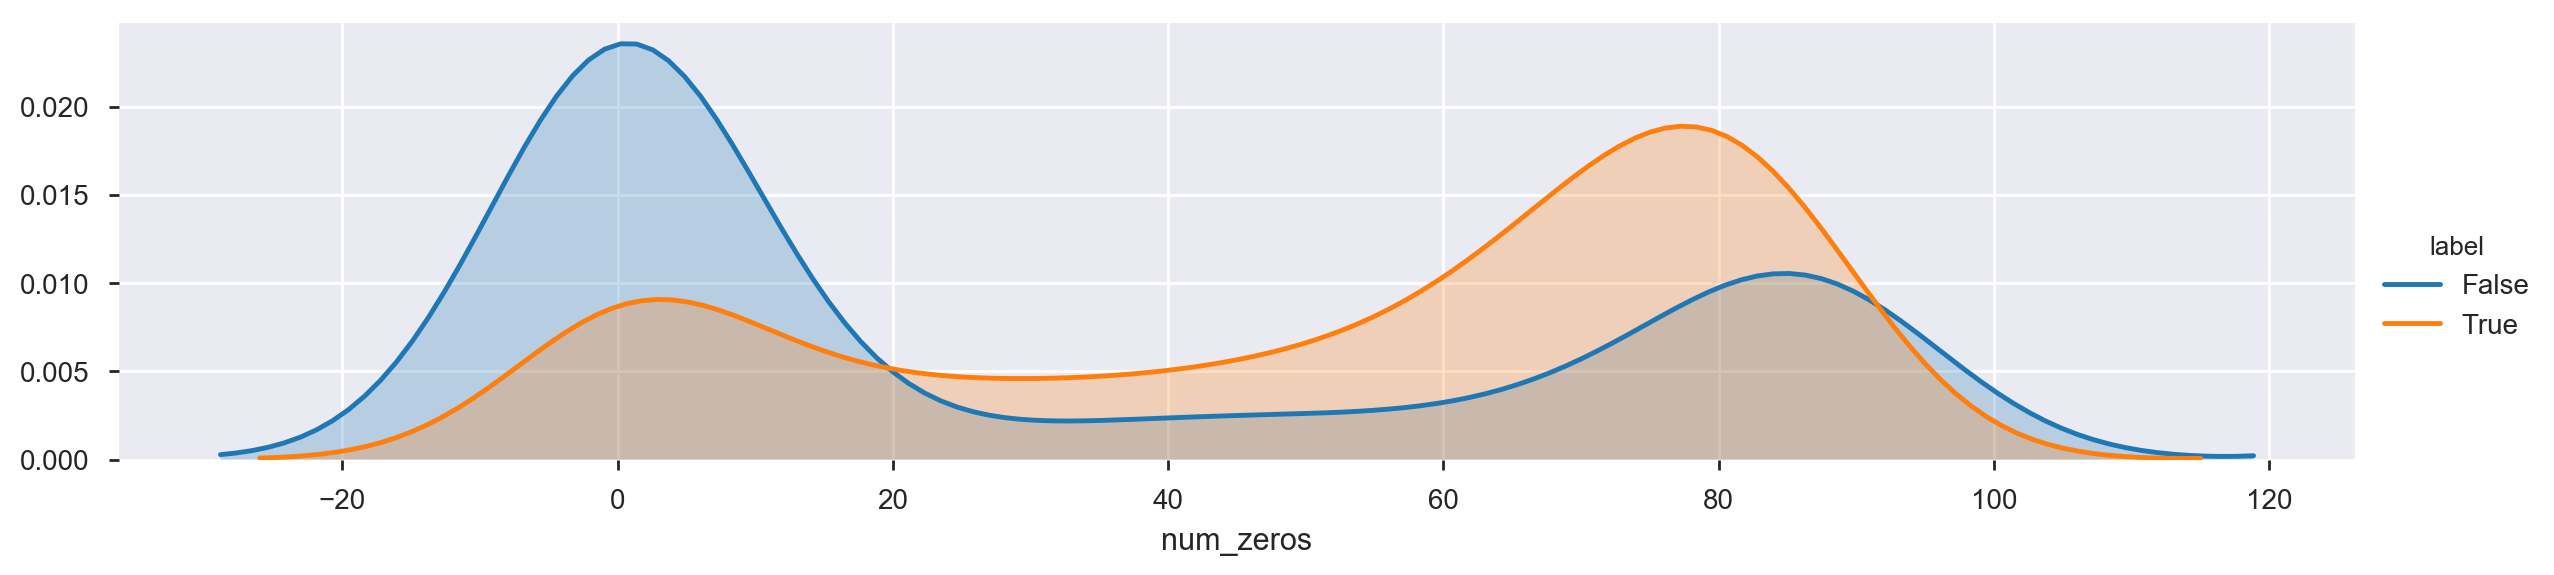

In [29]:
a = sns.FacetGrid(df, hue = 'label', aspect=4 )
a.map(sns.kdeplot, 'num_zeros', shade= True )
# a.set(xlim=(0 , 200))
a.add_legend()

## Number of outliers

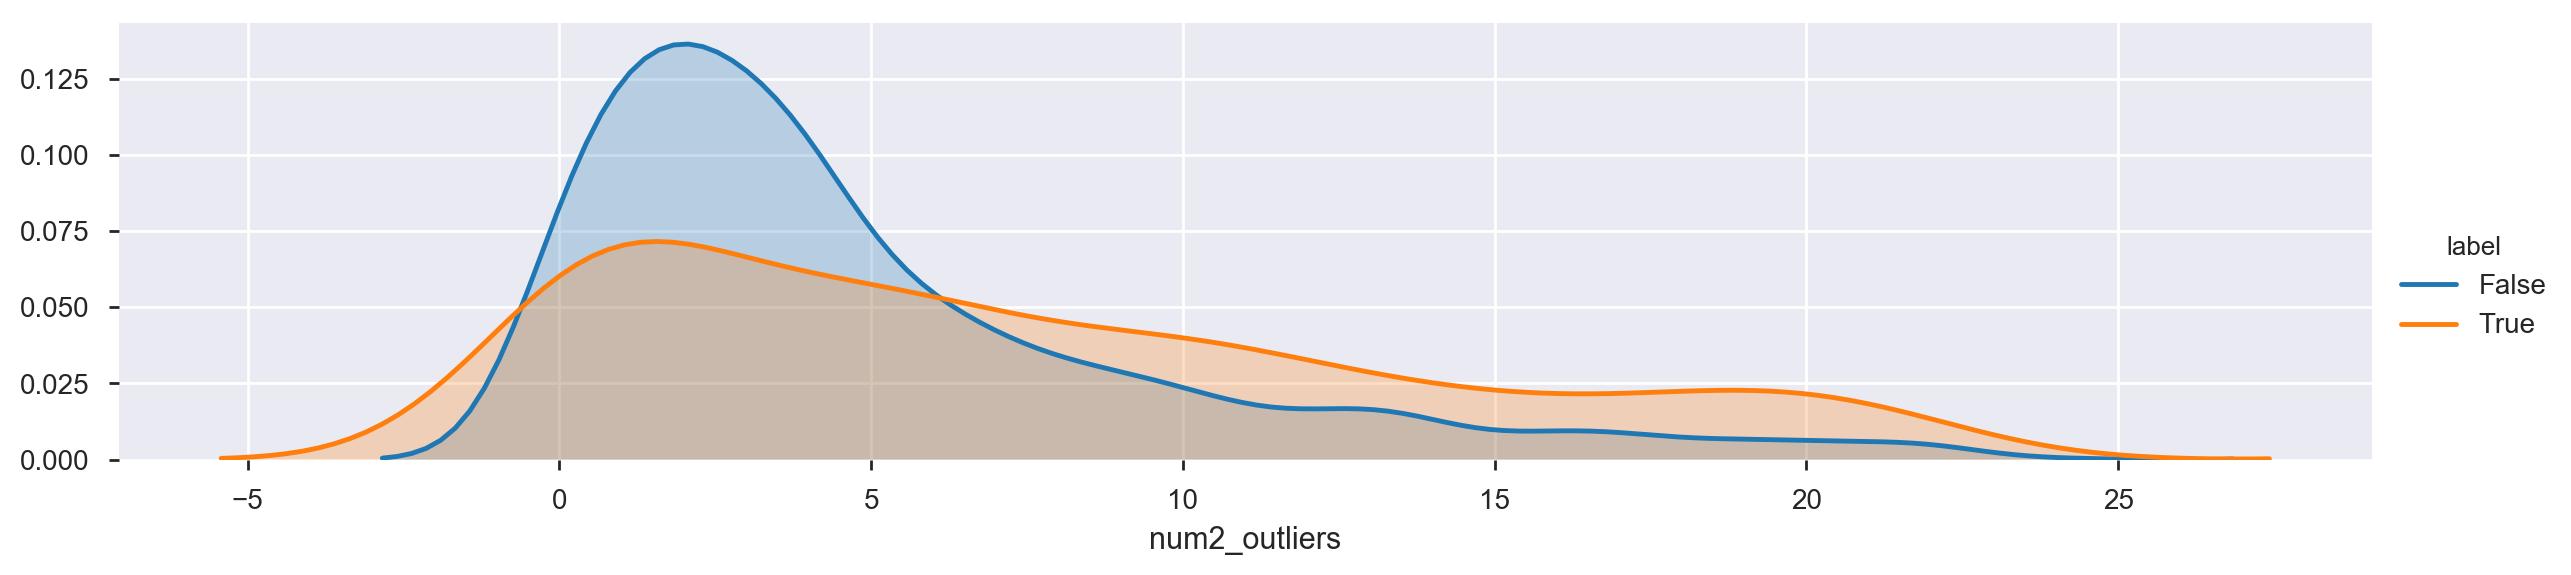

In [30]:
a = sns.FacetGrid(df, hue = 'label', aspect=4 )
a.map(sns.kdeplot, 'num2_outliers', shade= True )
# a.set(xlim=(0 , 200))
a.add_legend()

# 3. Build models

## Select features

In [31]:
target = 'label'
features = list(df)
features.remove(target)
features.remove('id')

X = df[features]
y = df[target]

## Train - test split

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1400, 19)
X_test : (600, 19)
y_train : (1400,)
y_test : (600,)


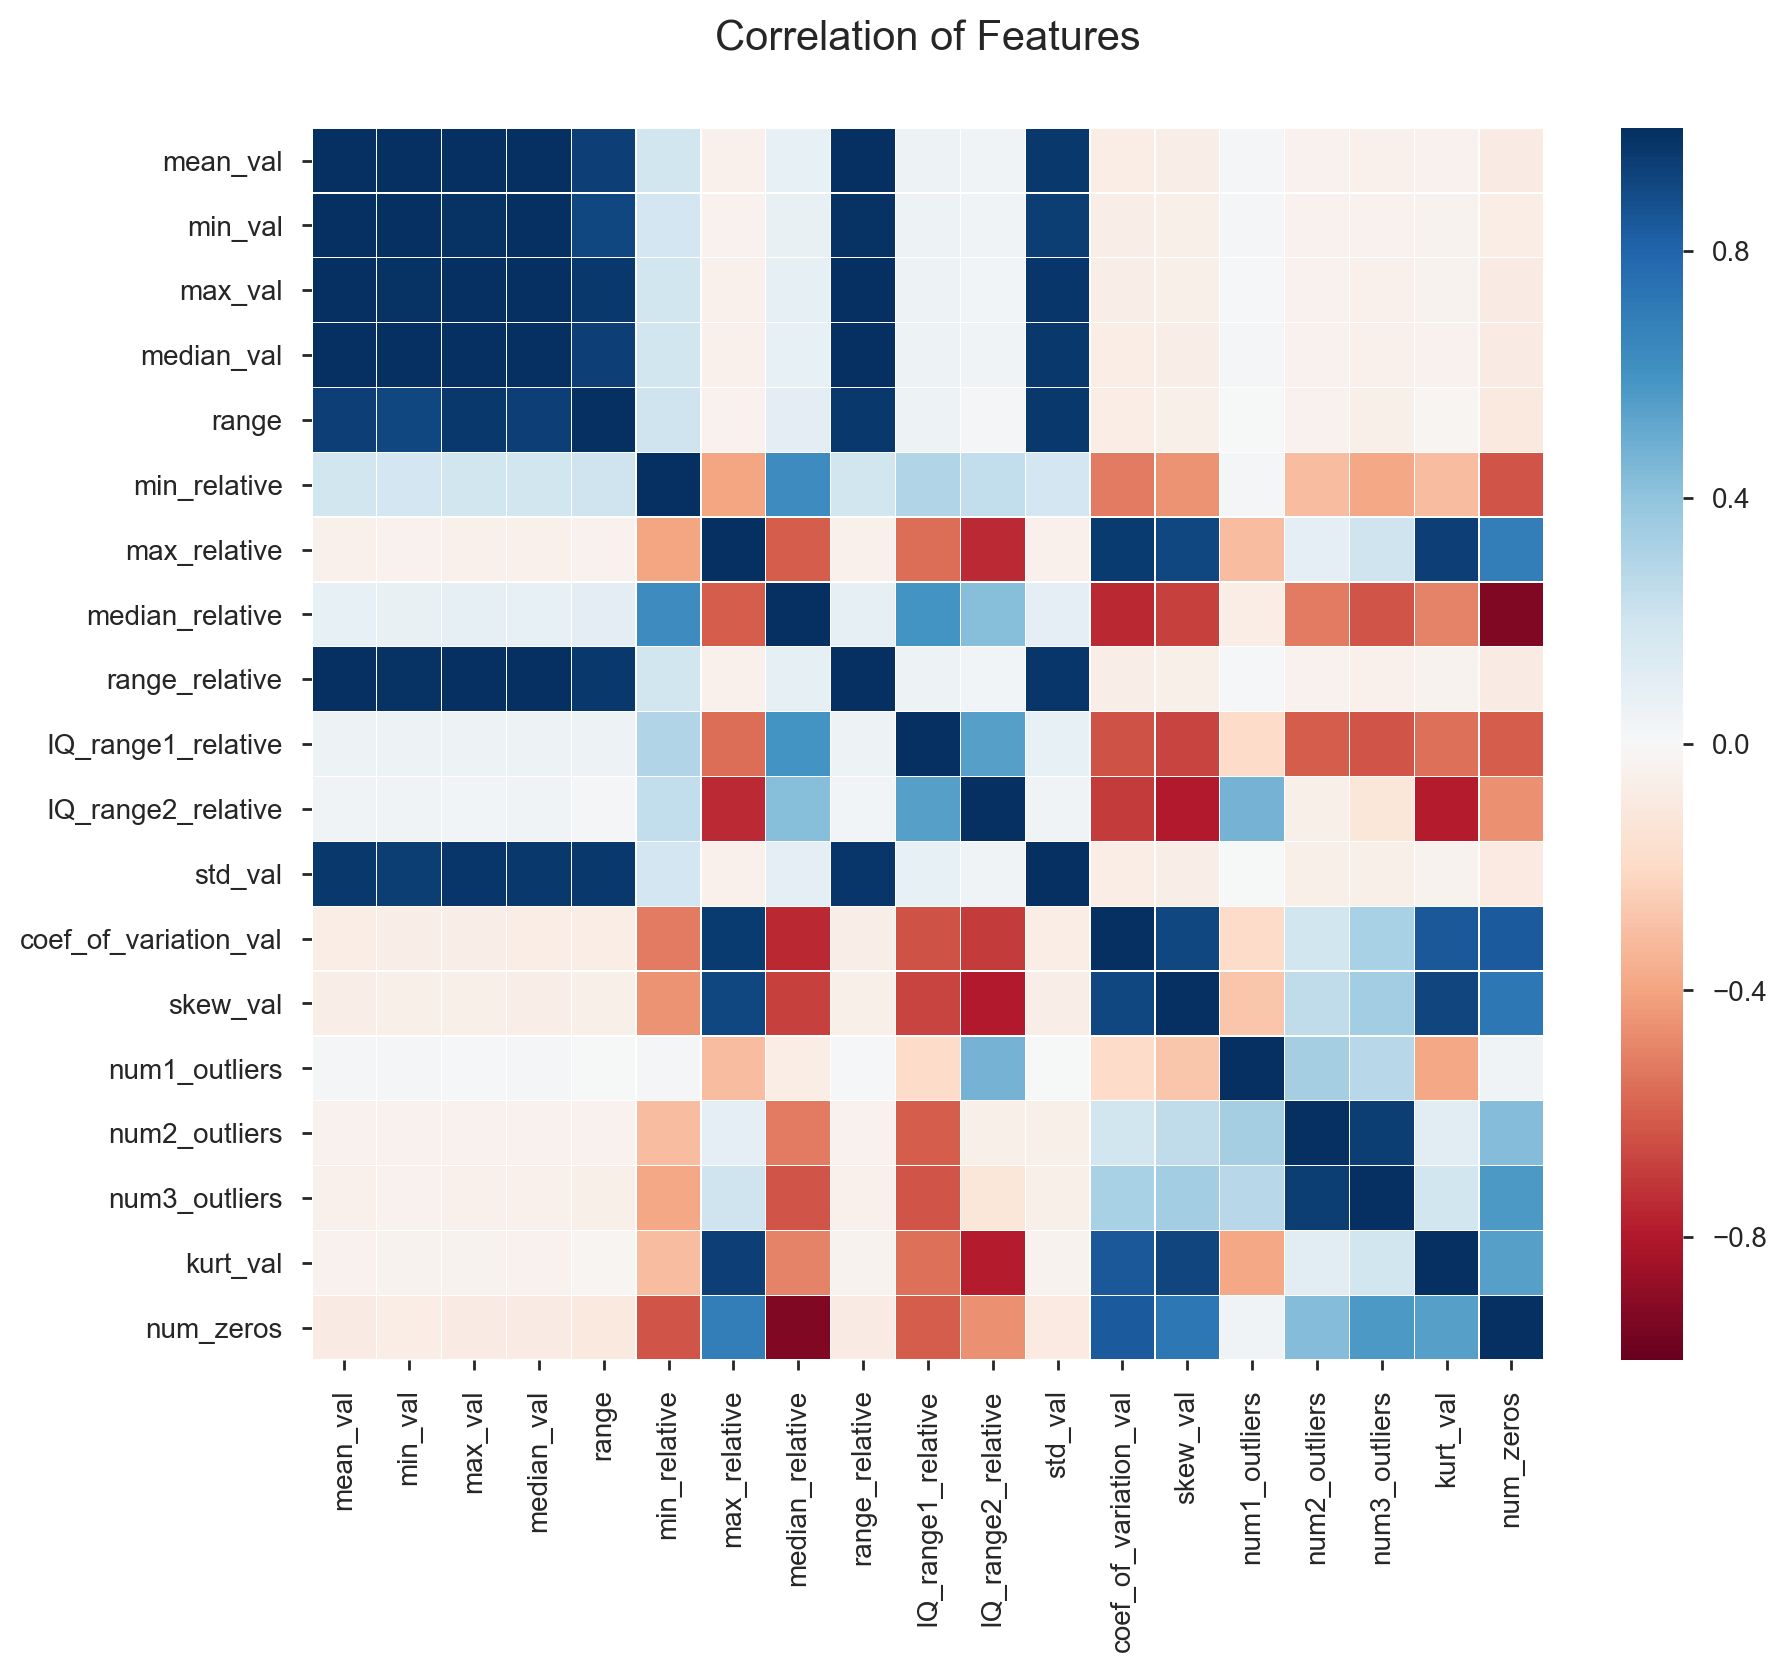

In [33]:
plt.figure(figsize=(10,8))
colormap = plt.cm.RdBu

plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(df[features].corr(),linewidths=0.1,vmax=1.0, vmin=-1,
            square=True, cmap=colormap, linecolor='white', annot=False)

## Define the confusion matrix plot function


In [34]:
import itertools
from sklearn.metrics import confusion_matrix

### confusion matrix plot function ###
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(4,4))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    

    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Compute and plot confusion matrix ###
def compute_and_plot_confusion_matrix(y, y_pred):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
#     plt.figure(figsize=(4,4))
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

In [35]:
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix,roc_curve, roc_auc_score, classification_report
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, f1_score

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pickle


from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [36]:
DT = tree.DecisionTreeClassifier(max_depth=6)
DT = DT.fit(X_train,y_train)

y_test_proba = DT.predict_proba(X_test)[:, 1]
y_test_pred = DT.predict(X_test)


print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.85      0.77      0.81       373
        True       0.67      0.77      0.72       227

   micro avg       0.77      0.77      0.77       600
   macro avg       0.76      0.77      0.76       600
weighted avg       0.78      0.77      0.77       600



Confusion matrix, without normalization
[[289  84]
 [ 53 174]]
Normalized confusion matrix
[[0.77 0.23]
 [0.23 0.77]]


<Figure size 800x550 with 0 Axes>

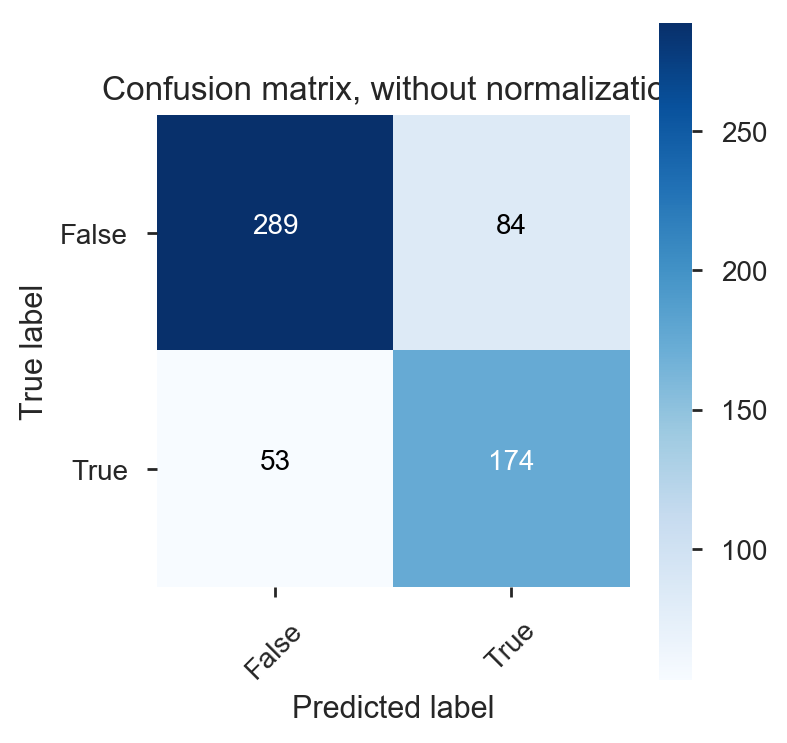

<Figure size 800x550 with 0 Axes>

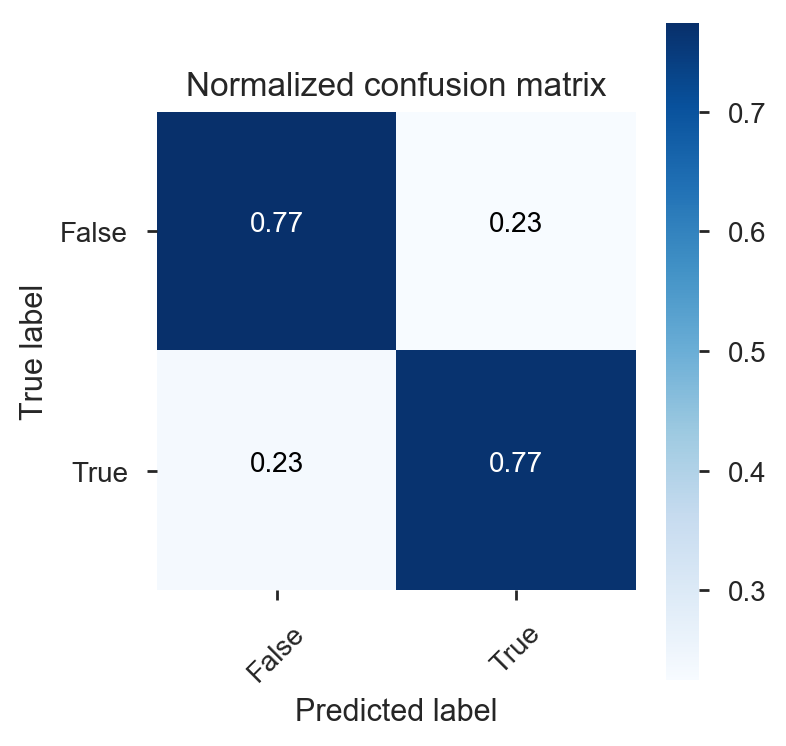

In [37]:
### confusion matrix for the test set ###
class_names = ['False','True']
compute_and_plot_confusion_matrix(y_test,y_test_pred)

In [38]:
RFC = RandomForestClassifier(max_depth=5, max_features=9, n_estimators = 300)
# oob_score = True, max_features=7, n_estimators = 100, n_jobs = -1
RFC = RFC.fit(X_train,y_train)
y_test_pred = RFC.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.85      0.84      0.85       373
        True       0.75      0.75      0.75       227

   micro avg       0.81      0.81      0.81       600
   macro avg       0.80      0.80      0.80       600
weighted avg       0.81      0.81      0.81       600



Confusion matrix, without normalization
[[315  58]
 [ 57 170]]
Normalized confusion matrix
[[0.84 0.16]
 [0.25 0.75]]


<Figure size 800x550 with 0 Axes>

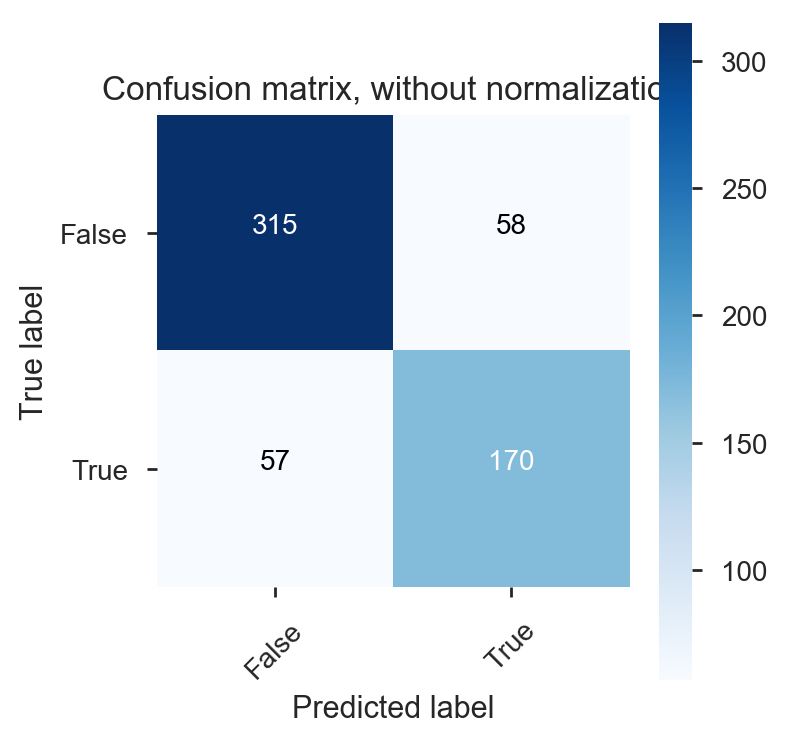

<Figure size 800x550 with 0 Axes>

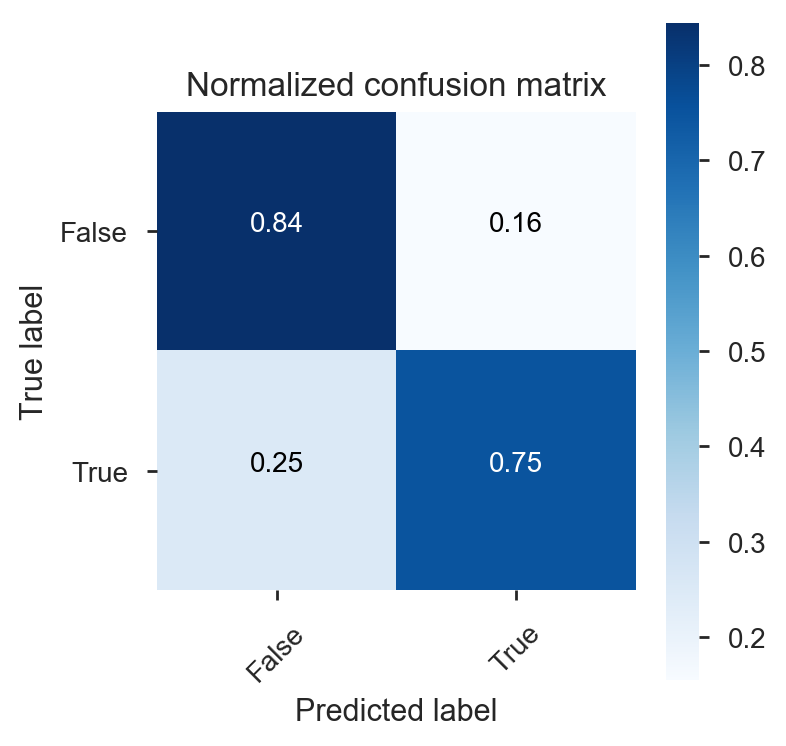

In [39]:
### confusion matrix for the test set ###
compute_and_plot_confusion_matrix(y_test, y_test_pred)

## In general, the features that measure the variability of the data are more important
### Feature importance can not be interpreted simply based on the ranking, due to collinearity

Text(0.5,1,'Random forest feature importance')

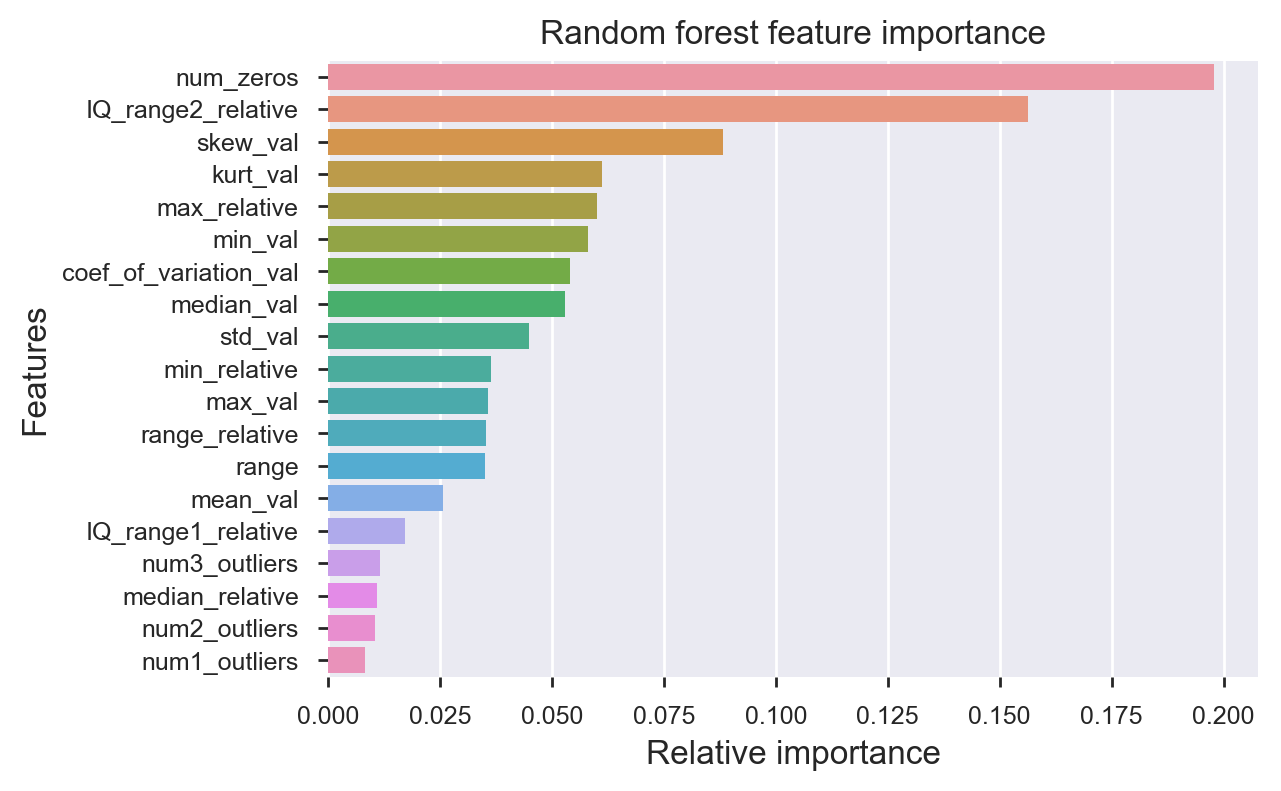

In [40]:
classifier= RFC
indices = np.argsort(classifier.feature_importances_)[::-1]
plt.figure(figsize=(6,4))
g = sns.barplot(y=X_train.columns[indices],
                x = classifier.feature_importances_[indices] , orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title("Random forest feature importance")

# 4. More Feature Engineering
### I mainly focused on the deriving features base on 'value' in section 2
### Now move focus to the time series related features

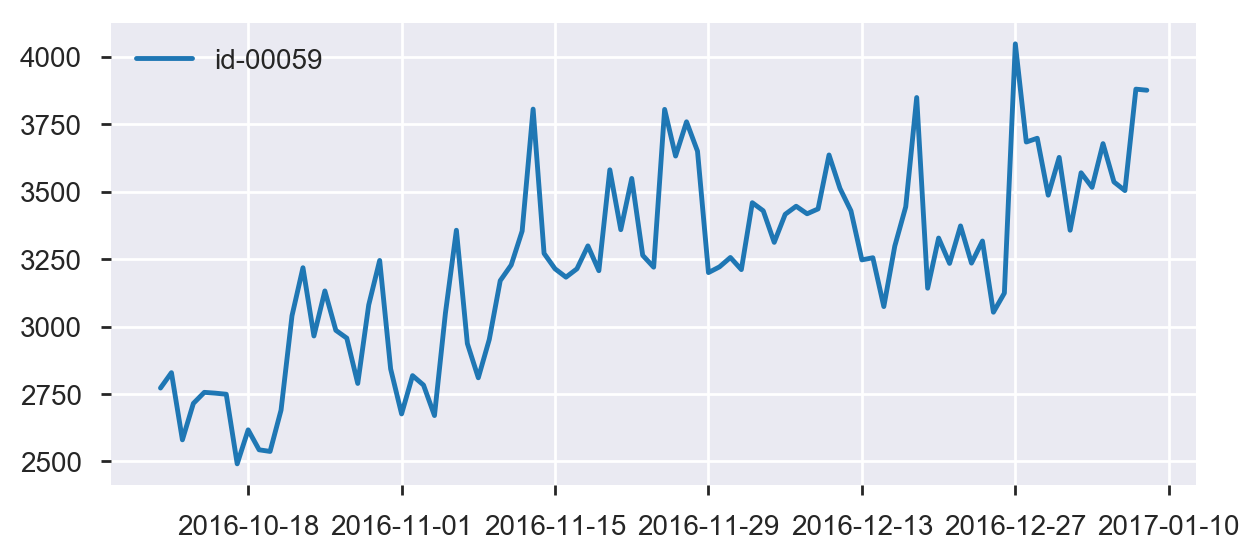

In [41]:
plot_id = 'id-00059'
plt.figure(figsize=(7,3))
plt.plot(data.loc[data.id == plot_id].Date, data.loc[data.id == plot_id].value)
plt.legend([plot_id])

## Plot a noisy example scales to a similar magnitude of the above example:
### much larger variation

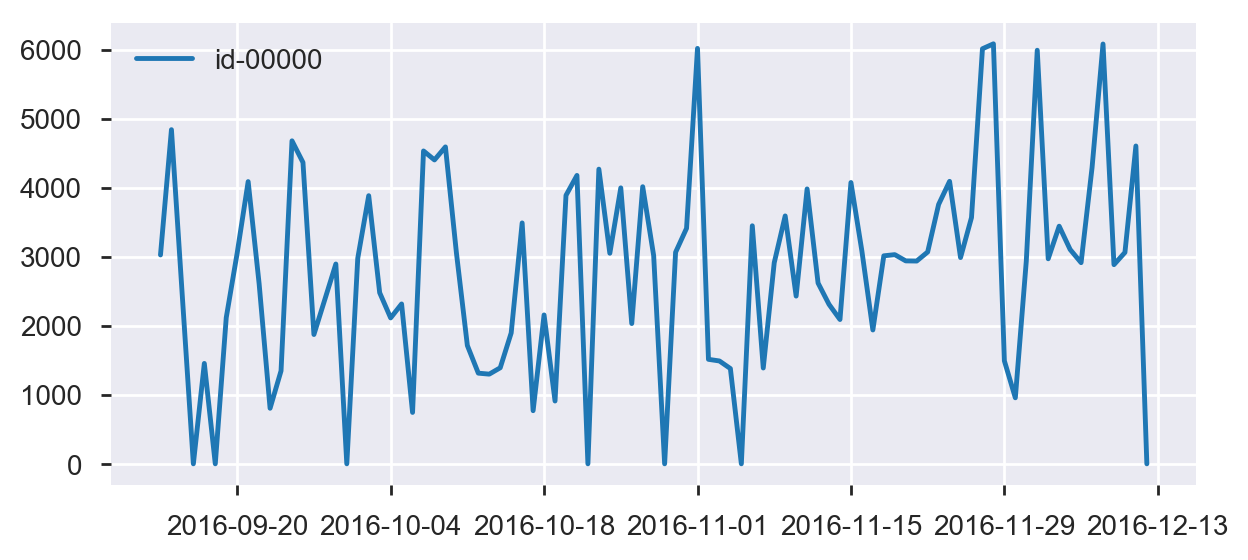

In [42]:
plot_id = 'id-00000'
plt.figure(figsize=(7,3))
plt.plot(data.loc[data.id == plot_id].Date, data.loc[data.id == plot_id].value*60)
plt.legend([plot_id])

### Only three examples starts in Jan, 2006, most span from Sep-Dec or Oct-Jan

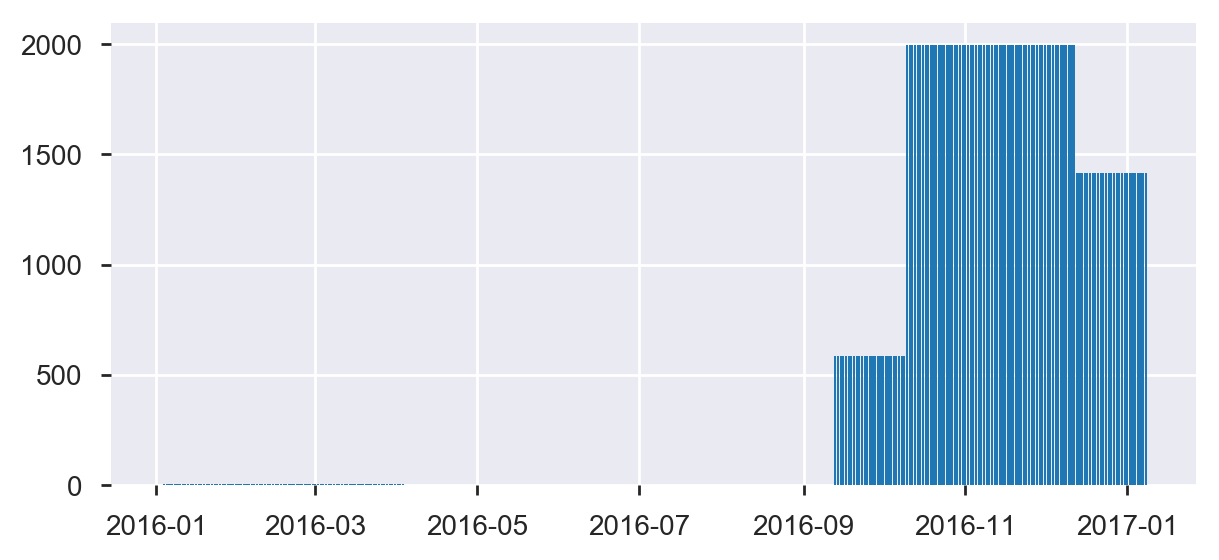

In [43]:
plt.figure(figsize=(7,3))
counts = data['Date'].value_counts(sort=False)
plt.bar(counts.index,counts)
plt.show()

## Create a feature: starts in september or not

In [44]:
df['starts_in_sep'] = 0
df['starts_in_sep'][:] = (data.groupby(data.id).agg({'Date':'first'}).Date == '2016-09-13').astype(int)

In [45]:
df.head()

,id,label,mean_val,min_val,max_val,median_val,range,min_relative,max_relative,median_relative,...,IQ_range2_relative,std_val,coef_of_variation_val,skew_val,num1_outliers,num2_outliers,num3_outliers,kurt_val,num_zeros,starts_in_sep
0,id-00000,True,46.429064,0.0,101.43895,49.014999,101.43895,0.0,2.184816,1.055696,...,0.890228,24.733014,0.529770,0.071467,5.0,0.0,0.0,-0.149305,7,1
1,id-00001,True,0.956044,0.0,12.00000,0.000000,12.00000,0.0,12.551724,0.000000,...,0.416667,1.993947,2.074131,3.122942,6.0,6.0,4.0,11.931713,63,0
2,id-00002,True,0.307692,0.0,2.00000,0.000000,2.00000,0.0,6.500000,0.000000,...,1.000000,0.710122,2.295181,1.949716,13.0,15.0,15.0,1.930770,76,0
3,id-00003,True,0.219780,0.0,2.00000,0.000000,2.00000,0.0,9.100000,0.000000,...,1.000000,0.611050,2.764959,2.533387,9.0,11.0,11.0,4.677329,80,1
4,id-00004,True,1.109890,0.0,5.00000,1.000000,5.00000,0.0,4.504950,0.900990,...,0.600000,1.224296,1.097001,0.751607,3.0,0.0,0.0,-0.180031,43,0


## Create a feature: stationary or not:
### Augmented Dickey-Fuller test
- https://machinelearningmastery.com/time-series-data-stationary-python/

In [46]:
from statsmodels.tsa.stattools import adfuller
df['is_stationary'] = 0
df['is_stationary'][:] = (data.groupby(data.id).agg({'value': lambda x: adfuller(x)[1]})<0.05).value.astype(int)

In [47]:
df.head()

,id,label,mean_val,min_val,max_val,median_val,range,min_relative,max_relative,median_relative,...,std_val,coef_of_variation_val,skew_val,num1_outliers,num2_outliers,num3_outliers,kurt_val,num_zeros,starts_in_sep,is_stationary
0,id-00000,True,46.429064,0.0,101.43895,49.014999,101.43895,0.0,2.184816,1.055696,...,24.733014,0.529770,0.071467,5.0,0.0,0.0,-0.149305,7,1,1
1,id-00001,True,0.956044,0.0,12.00000,0.000000,12.00000,0.0,12.551724,0.000000,...,1.993947,2.074131,3.122942,6.0,6.0,4.0,11.931713,63,0,1
2,id-00002,True,0.307692,0.0,2.00000,0.000000,2.00000,0.0,6.500000,0.000000,...,0.710122,2.295181,1.949716,13.0,15.0,15.0,1.930770,76,0,1
3,id-00003,True,0.219780,0.0,2.00000,0.000000,2.00000,0.0,9.100000,0.000000,...,0.611050,2.764959,2.533387,9.0,11.0,11.0,4.677329,80,1,1
4,id-00004,True,1.109890,0.0,5.00000,1.000000,5.00000,0.0,4.504950,0.900990,...,1.224296,1.097001,0.751607,3.0,0.0,0.0,-0.180031,43,0,1


## Stationary examples have a higher chance of being noisy

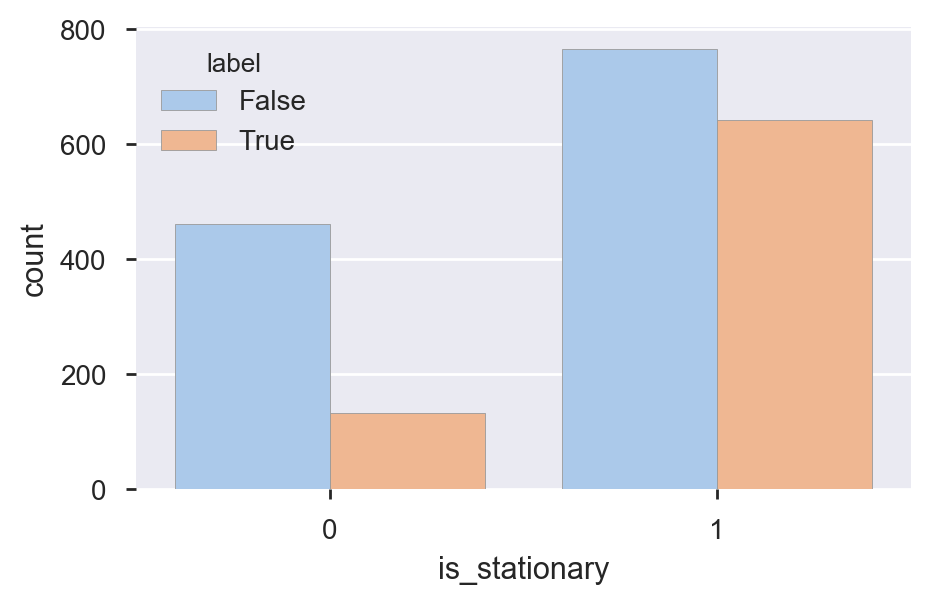

In [48]:
plt.figure(figsize=(5,3))
sns.countplot(x='is_stationary', hue='label',  palette="pastel", edgecolor=".6", data=df)#palette="pastel", 

In [49]:
# data['lag_1'] = abs(data.value - data.value.shift(1))
# data['lag_1'].iloc[0] = 0
# data['lag_2'] = abs(data.value - data.value.shift(2))
# data['lag_2'].iloc[0] = 0
# data['lag_2'].iloc[1] = 0

## Add autocorrelation features, take absolute values

In [50]:
df['auto_corr1'] = 0
df['auto_corr1'][:] = abs(data.groupby(data.id).agg({'value': lambda x: x.autocorr(lag=1)}).value)
df['auto_corr1_is_positive'] = 0
df['auto_corr1_is_positive'][:] = (data.groupby(data.id).agg({'value': lambda x: x.autocorr(lag=1)}).value>0).astype(int)
df['auto_corr2'] = 0
df['auto_corr2'][:] = abs(data.groupby(data.id).agg({'value': lambda x: x.autocorr(lag=2)}).value)
df['auto_corr2_is_positive'] = 0
df['auto_corr2_is_positive'][:] = (data.groupby(data.id).agg({'value': lambda x: x.autocorr(lag=2)}).value>0).astype(int)
df['auto_corr3'] = 0
df['auto_corr3'][:] = abs(data.groupby(data.id).agg({'value': lambda x: x.autocorr(lag=3)}).value)
df['auto_corr3_is_positive'] = 0
df['auto_corr3_is_positive'][:] = (data.groupby(data.id).agg({'value': lambda x: x.autocorr(lag=3)}).value>0).astype(int)

## Looks like the noisy examples have lower autocorrlations

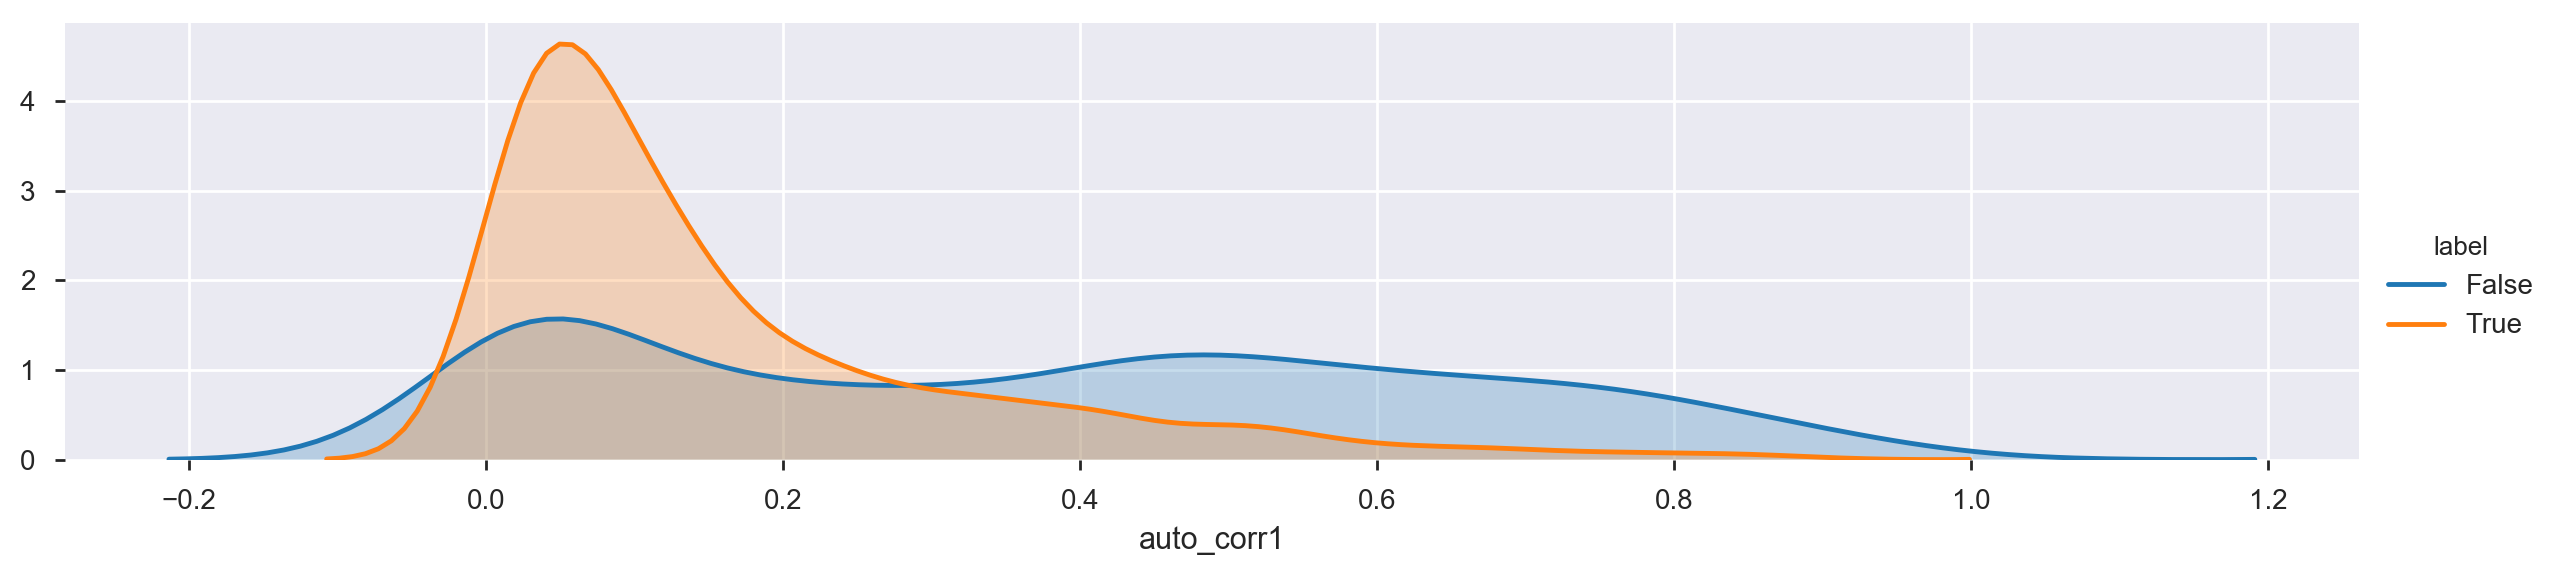

In [51]:
a = sns.FacetGrid(df, hue = 'label', aspect=4 )
a.map(sns.kdeplot, 'auto_corr1', shade= True )
a.add_legend()

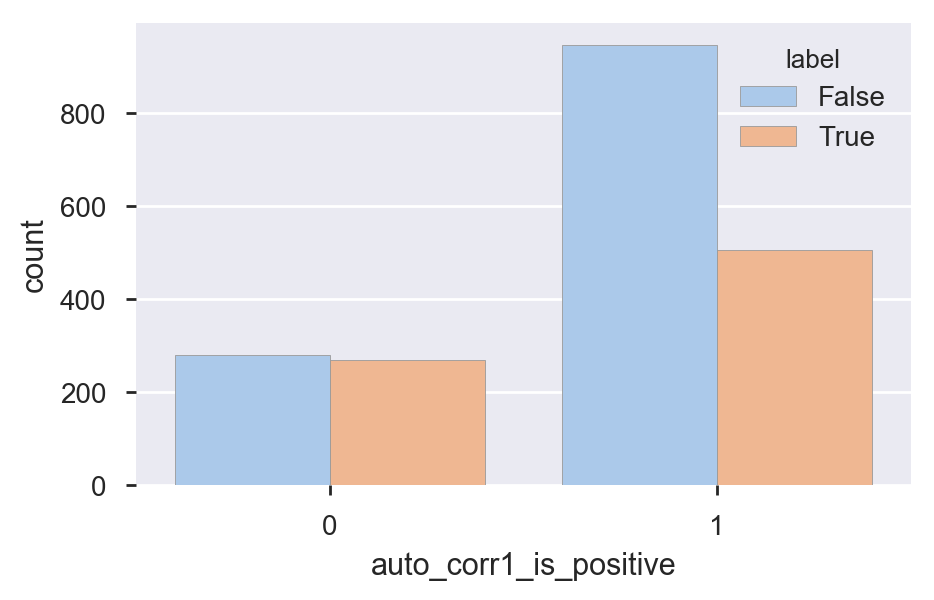

In [52]:
plt.figure(figsize=(5,3))
sns.countplot(x='auto_corr1_is_positive', hue='label',  palette="pastel", edgecolor=".6", data=df)#palette="pastel", 

In [53]:
for col in ['auto_corr1','auto_corr2','auto_corr3']:
    df[col] = df[col].fillna(0)

## Add another feature: number of peaks

In [54]:
# code from https://tsfresh.readthedocs.io/en/latest/_modules/tsfresh/feature_extraction/feature_calculators.html
def _roll(a, shift):
    if not isinstance(a, np.ndarray):
        a = np.asarray(a)
    idx = shift % len(a)
    return np.concatenate([a[-idx:], a[:-idx]])

def number_peaks1(x):    
    n=1
    x_reduced = x[n:-n]

    res = None
    for i in range(1, n + 1):
        result_first = (x_reduced > _roll(x, i)[n:-n])

        if res is None:
            res = result_first
        else:
            res &= result_first

        res &= (x_reduced > _roll(x, -i)[n:-n])
    return np.sum(res)

def number_peaks2(x):    
    n=2
    x_reduced = x[n:-n]

    res = None
    for i in range(1, n + 1):
        result_first = (x_reduced > _roll(x, i)[n:-n])

        if res is None:
            res = result_first
        else:
            res &= result_first

        res &= (x_reduced > _roll(x, -i)[n:-n])
    return np.sum(res)

In [55]:
df['num_of_peaks1'] = 0
df['num_of_peaks1'][:] = data.groupby(data.id).agg({'value': lambda x: number_peaks1(x)}).value.astype(int)
df['num_of_peaks2'] = 0
df['num_of_peaks2'][:] = data.groupby(data.id).agg({'value': lambda x: number_peaks2(x)}).value.astype(int)

In [56]:
df.head()

,id,label,mean_val,min_val,max_val,median_val,range,min_relative,max_relative,median_relative,...,starts_in_sep,is_stationary,auto_corr1,auto_corr1_is_positive,auto_corr2,auto_corr2_is_positive,auto_corr3,auto_corr3_is_positive,num_of_peaks1,num_of_peaks2
0,id-00000,True,46.429064,0.0,101.43895,49.014999,101.43895,0.0,2.184816,1.055696,...,1,1,0.147302,1,0.090050,0,0.075503,0,27,16
1,id-00001,True,0.956044,0.0,12.00000,0.000000,12.00000,0.0,12.551724,0.000000,...,0,1,0.134555,1,0.093785,0,0.044894,1,19,13
2,id-00002,True,0.307692,0.0,2.00000,0.000000,2.00000,0.0,6.500000,0.000000,...,0,1,0.053222,0,0.010986,0,0.075921,1,11,9
3,id-00003,True,0.219780,0.0,2.00000,0.000000,2.00000,0.0,9.100000,0.000000,...,1,1,0.344371,1,0.134474,1,0.135870,0,5,3
4,id-00004,True,1.109890,0.0,5.00000,1.000000,5.00000,0.0,4.504950,0.900990,...,0,1,0.015266,1,0.066955,1,0.065576,1,22,10


## Looks like noisy examples have fewer peaks, which is a little counterintuitive

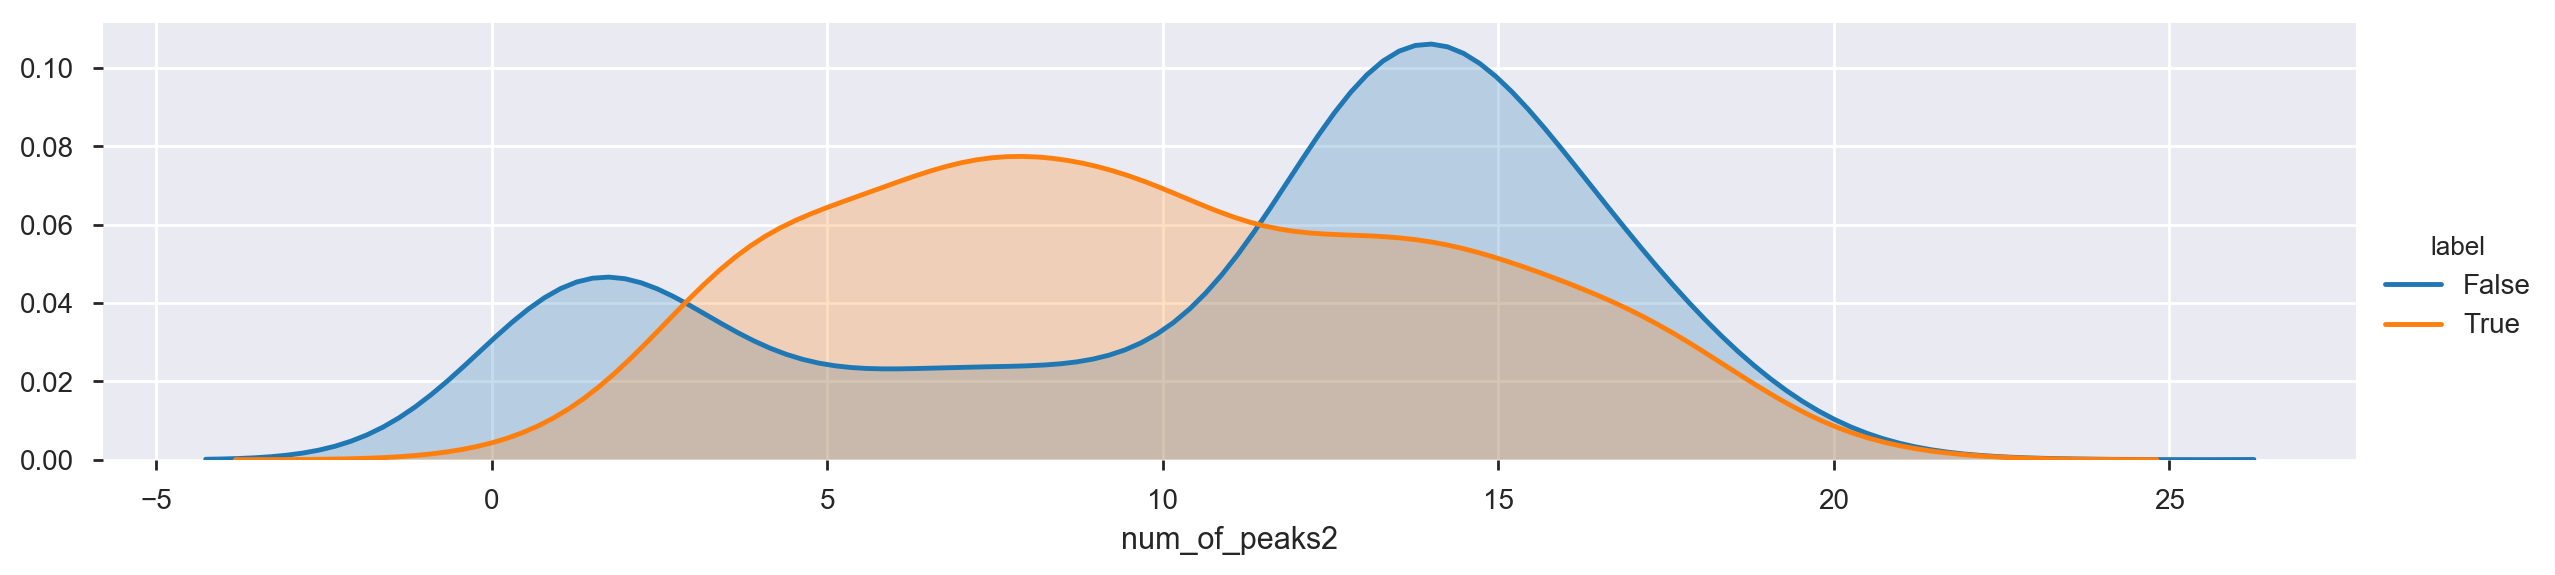

In [57]:
a = sns.FacetGrid(df, hue = 'label', aspect=4 )
a.map(sns.kdeplot, 'num_of_peaks2', shade= True )
a.add_legend()

# 5. Build the final model

## Select features

In [58]:
target = 'label'
features = list(df)
features.remove(target)
features.remove('id')

X = df[features]
y = df[target]

## Train - test split

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,  random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1400, 29)
X_test : (600, 29)
y_train : (1400,)
y_test : (600,)


In [60]:
# # train-test split:
# X_train, X_test, y_train, y_test = \
# train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# # train-cross validation split:
# X_train,  X_cross, y_train, y_cross= \
# train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# print("X_train : " + str(X_train.shape))
# print("X_test : " + str(X_test.shape))
# print("y_train : " + str(y_train.shape))
# print("y_test : " + str(y_test.shape))

## Compare the performance of a few classifiers
### Random forest seems to perform better

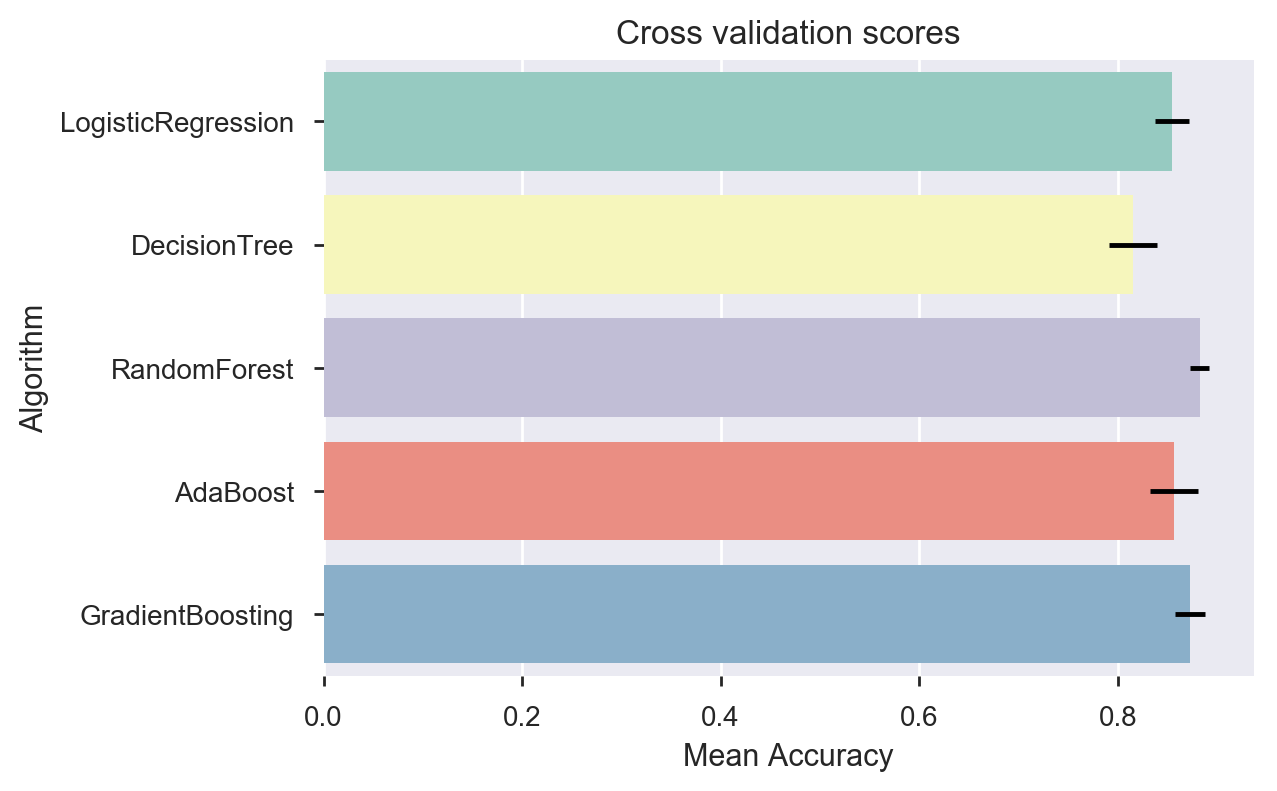

In [61]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=5)

random_state = 2
classifiers = []
classifier_names = ["LogisticRegression","DecisionTree","RandomForest","AdaBoost","GradientBoosting"]

# classifier_names = ["DecisionTree","AdaBoost",
# "RandomForest","GradientBoosting","LogisticRegression"]

classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state, max_depth=6))
classifiers.append(RandomForestClassifier(random_state=random_state,max_depth=5, max_features=8, n_estimators = 300))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state, max_depth=6),random_state=random_state,learning_rate=0.05))


classifiers.append(GradientBoostingClassifier(random_state=random_state,n_estimators = 1000, max_depth=7 ))


cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "roc_auc", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())



cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":classifier_names})
plt.figure(figsize=(6,4))
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [62]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('Recall', fontsize=16)

## Chosse logistic regression and random forest for further analysis

## Logistic regression does a decent job

In [63]:
# Create logistic regression
logistic = LogisticRegression(solver='liblinear')
# Train on the training set:
logistic.fit(X_train, y_train)

y_cross_pred = cross_val_predict(logistic, X_train, y_train, cv=5)
y_scores = cross_val_predict(logistic, X_train, y_train, cv=5, method="decision_function")
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

y_test_pred = logistic.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.83      0.84      0.83       373
        True       0.73      0.71      0.72       227

   micro avg       0.79      0.79      0.79       600
   macro avg       0.78      0.78      0.78       600
weighted avg       0.79      0.79      0.79       600



## Random forest performs better

In [64]:
forest= RandomForestClassifier(random_state=42, max_depth=8, max_features=9, n_estimators = 300)
model=forest.fit(X_train, y_train)
y_probas_forest = cross_val_predict(model, X_train, y_train, cv=5, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train,y_scores_forest)

y_test_pred = forest.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.85      0.86      0.86       373
        True       0.77      0.75      0.76       227

   micro avg       0.82      0.82      0.82       600
   macro avg       0.81      0.81      0.81       600
weighted avg       0.82      0.82      0.82       600



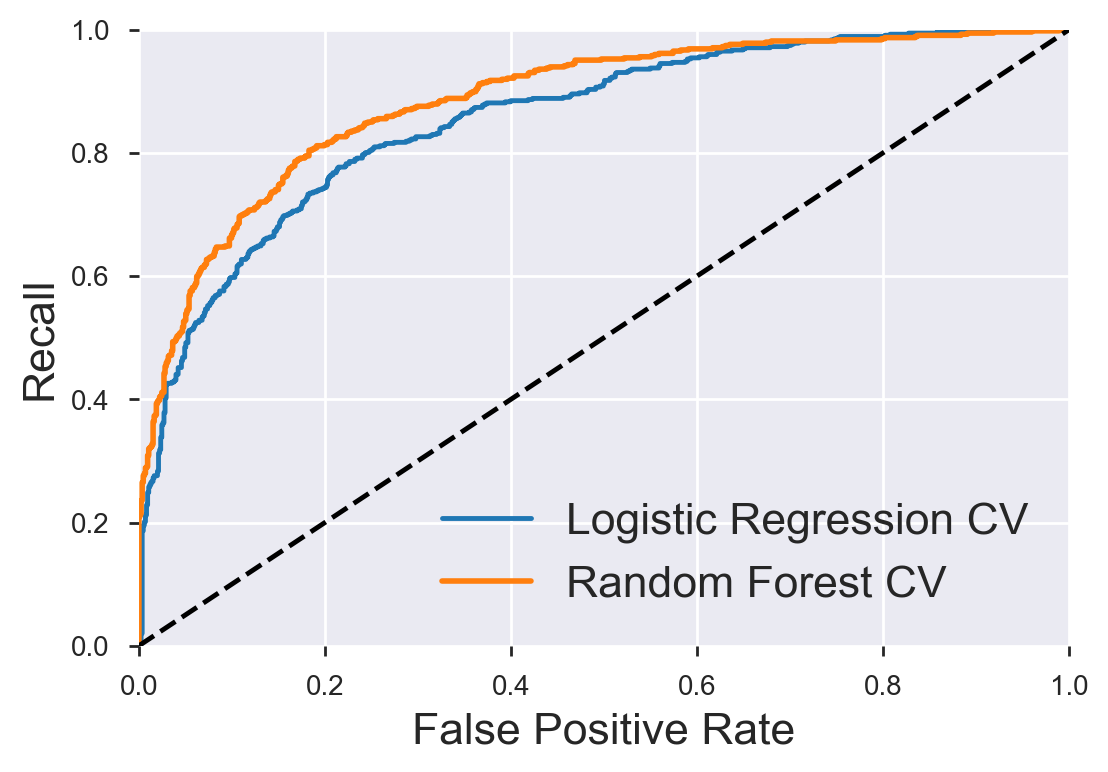

In [65]:
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="Logistic Regression CV")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest CV")
plt.legend(loc="best",fontsize=16)
plt.show();

## Hyper-parameter tuning using grid search: commented, takes too long to run
### Not much improvement so commented

In [66]:
# param_grid = [{'n_estimators': [30], 'max_features': [6,8,10,12,14,15,16,17,18,19,20], 'max_depth': [4,5,6,7,8,9,10,12]}]
# param_grid = [{'n_estimators': [200,300], 'max_features': [12,15,16,17], 'max_depth': [5,6,7,10]}]
# param_grid = [{'n_estimators': [200], 'max_features': [8,12,15,18], 'max_depth': [4,5,6,8]}]
# param_grid = [{'n_estimators': [200], 'max_features': [15], 'max_depth': [5,6,7]}]

# grid_search = GridSearchCV(forest, param_grid, cv=3, scoring='roc_auc')

# best_model=grid_search.fit(X_train, y_train)

# best_model.best_params_

In [67]:
# # evaluate: 
# y_probas_best_model = cross_val_predict(best_model.best_estimator_, X_train, y_train, cv=5, method="predict_proba")
# y_cross_proba = y_probas_best_model[:, 1] # score = proba of positive class
# # calculate rates:
# fpr_grid_search, tpr_grid_search, thresholds_grid_search = roc_curve(y_train,y_cross_proba)

# y_test_pred = best_model.best_estimator_.predict(X_test)
# print(classification_report(y_test, y_test_pred))

In [68]:
# # plot the results:
# plt.figure(figsize=(8,6))
# plt.plot(fpr, tpr, label="Logistic Regression")
# plt.plot(fpr_grid_search, tpr_grid_search, label="Random Forest Optimized")
# plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
# plt.legend(loc="best",fontsize=16)
# plt.show();

In [69]:
# classifier= best_model.best_estimator_
# indices = np.argsort(classifier.feature_importances_)[::-1]
# plt.figure(figsize=(6,4))
# g = sns.barplot(y=X_train.columns[indices],
#                 x = classifier.feature_importances_[indices] , orient='h')
# g.set_xlabel("Relative importance",fontsize=12)
# g.set_ylabel("Features",fontsize=12)
# g.tick_params(labelsize=9)
# g.set_title("Random forest feature importance")

In [70]:
# y_test_pred = best_model.best_estimator_.predict(X_test)
# y_test_proba = best_model.best_estimator_.predict_proba(X_test)

# # evaluate the test set:
# y_test_proba_final = y_test_proba[:, 1] # score = proba of positive class

# fpr_final, tpr_final, thresholds_final = roc_curve(y_test,y_test_proba_final)

## Test performs a little better than the training

In [71]:
y_test_pred = forest.predict(X_test)
y_test_proba = forest.predict_proba(X_test)

# evaluate the test set:
y_test_proba = y_test_proba[:, 1] # score = proba of positive class

fpr_final, tpr_final, thresholds_final = roc_curve(y_test,y_test_proba)

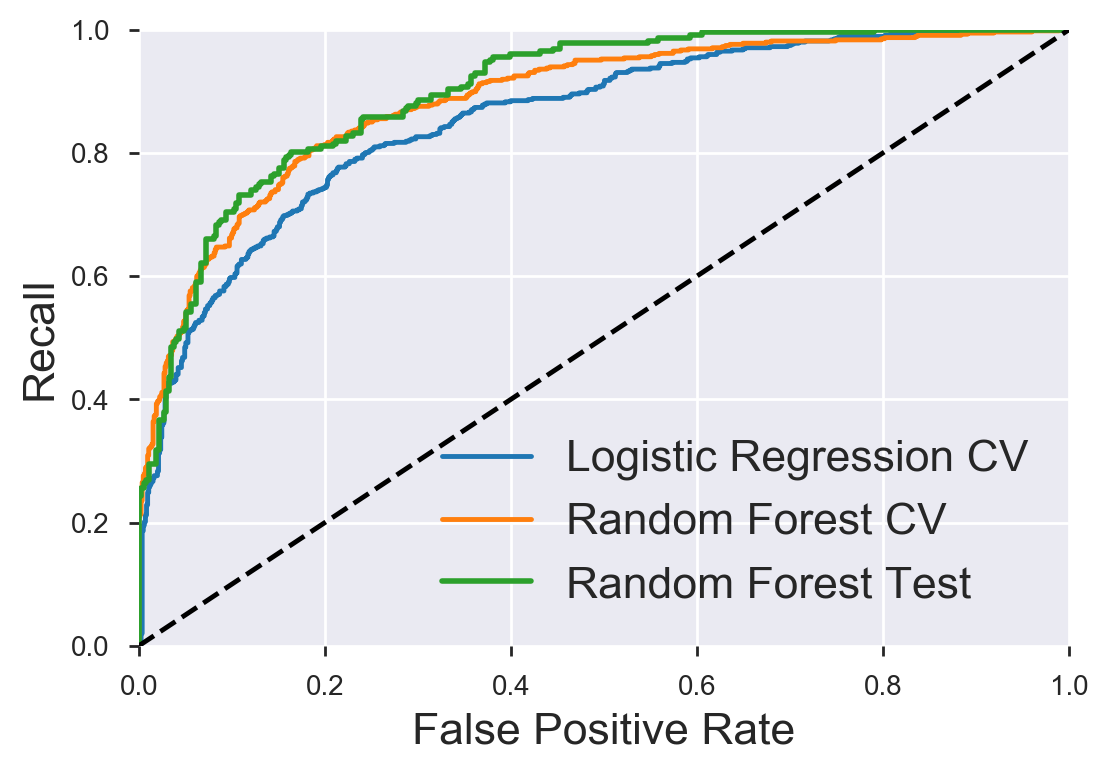

In [74]:
# plot the final results:
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="Logistic Regression CV")
plt.plot(fpr_forest, tpr_forest, label="Random Forest CV")
# plt.plot(fpr_grid_search, tpr_grid_search, label="Random Forest Optimized CV")
plot_roc_curve(fpr_final, tpr_final, "Random Forest Test")
plt.legend(loc="best",fontsize=16)
plt.show();

In [75]:
roc_auc_score(y_test, y_test_proba)

0.8983713431989702

## Choosing the threshold:
#### It's not very clear whether correctly classify one class is more important than the other
### But assuming we care more about identifying the noisy examples
1. The final ROC curves shows that a <b> Recall of 81%  </b></br> can be achieved if we accept a  <b> False Positive Rate of ~20% </b></br>.
2. A <b> Recall of 85%  </b></br> can be achieved if we accept a  <b> False Positive Rate of ~25% </b></br>.

In [76]:
threshold = 0.415
y_test_proba = forest.predict_proba(X_test)
y_test_pred = (y_test_proba [:,1] >= threshold).astype('int')

In [77]:
# y_test_pred = forest.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.87      0.80      0.84       373
        True       0.72      0.81      0.76       227

   micro avg       0.81      0.81      0.81       600
   macro avg       0.80      0.81      0.80       600
weighted avg       0.81      0.81      0.81       600



Confusion matrix, without normalization
[[300  73]
 [ 43 184]]
Normalized confusion matrix
[[0.8  0.2 ]
 [0.19 0.81]]


<Figure size 800x550 with 0 Axes>

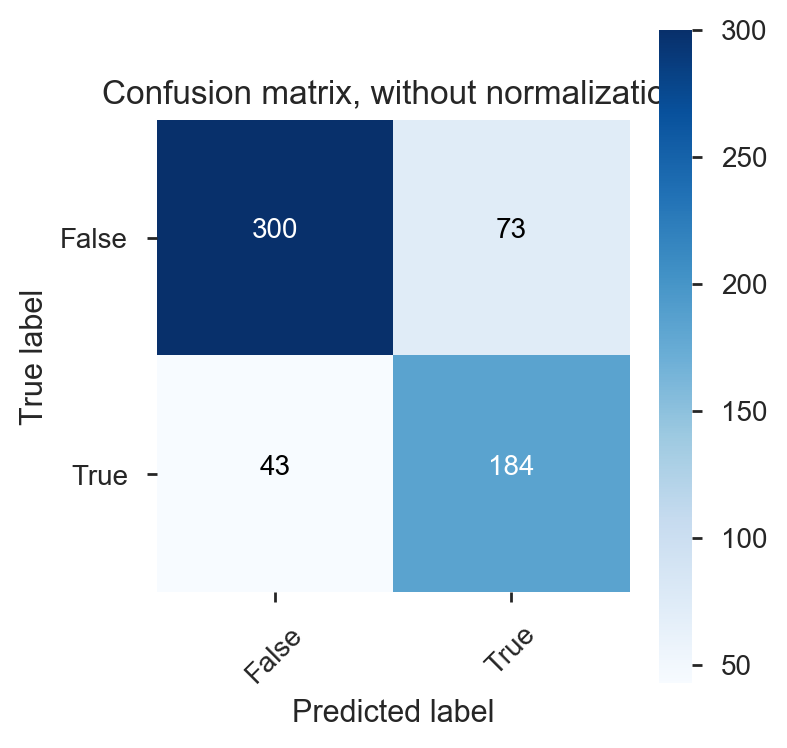

<Figure size 800x550 with 0 Axes>

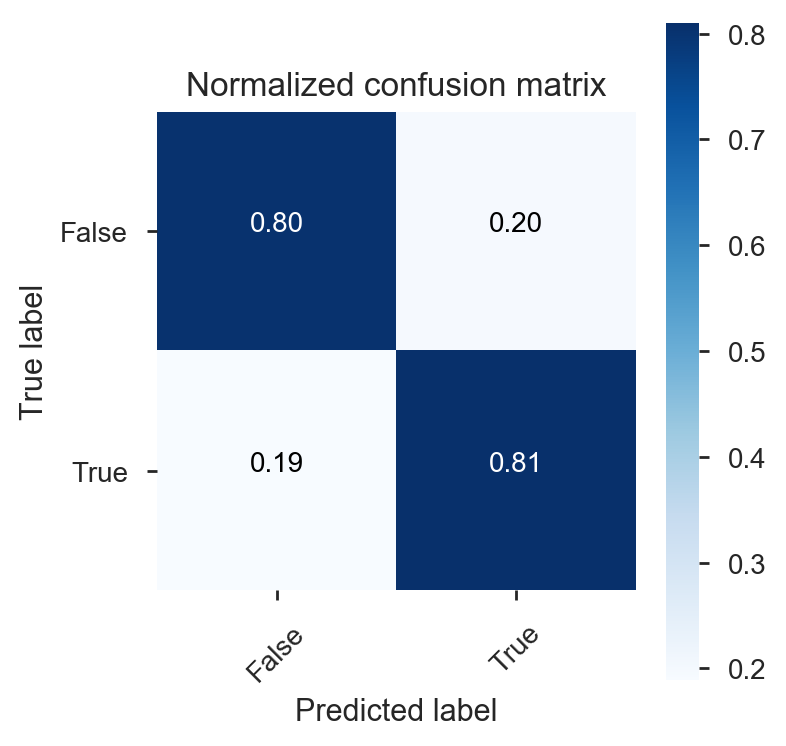

In [78]:
### confusion matrix for the test set ###
compute_and_plot_confusion_matrix(y_test, y_test_pred)

Text(0.5,1,'Random forest feature importance')

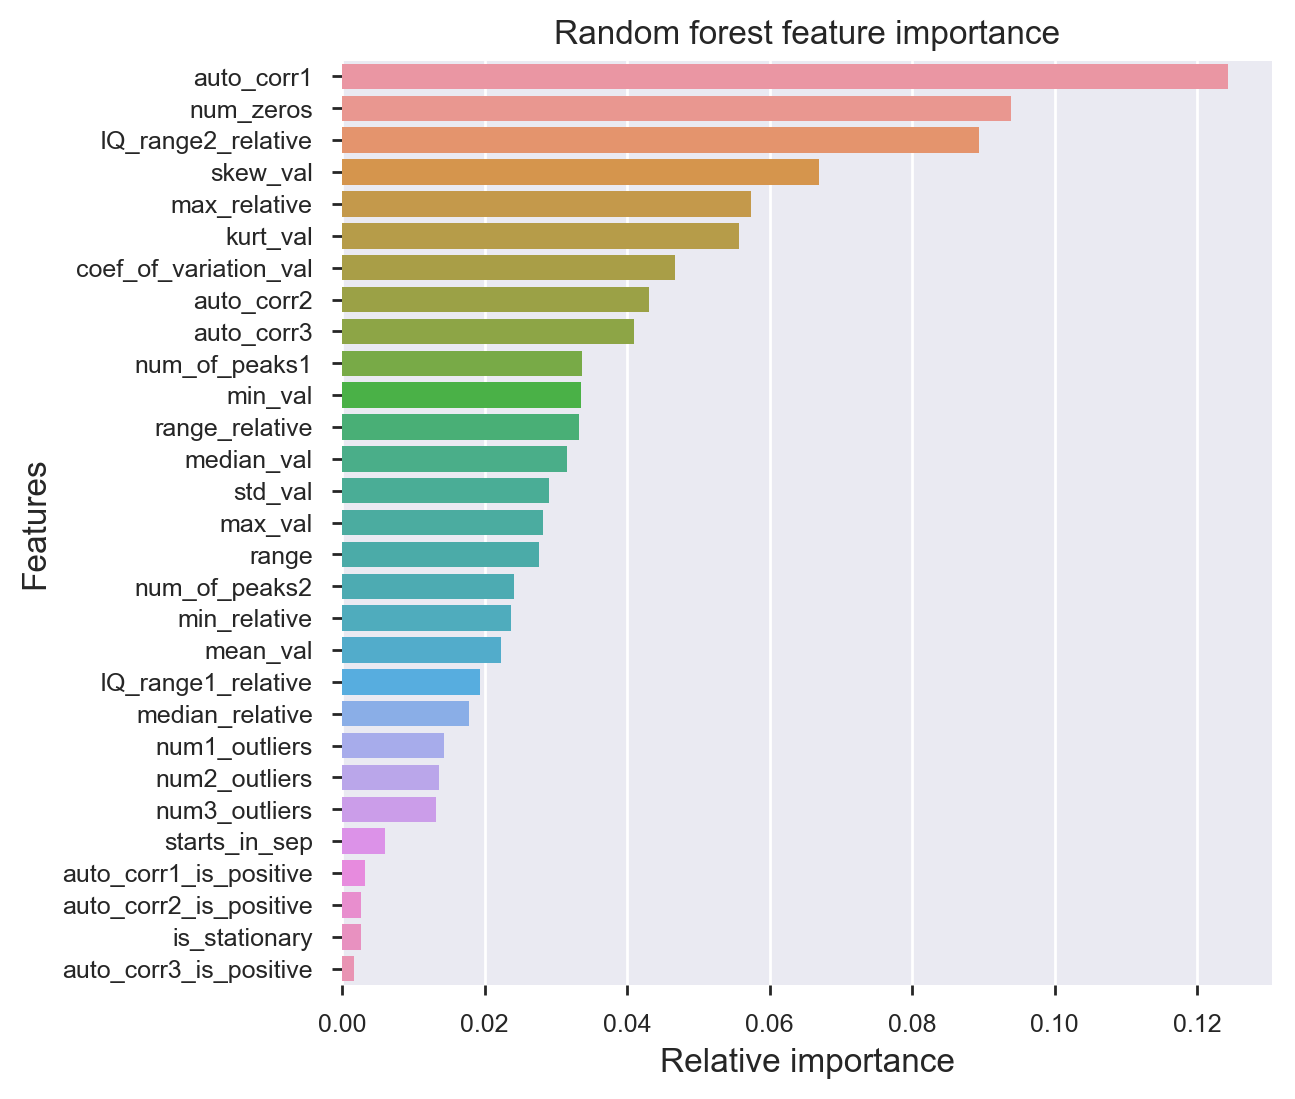

In [79]:
classifier= forest
indices = np.argsort(classifier.feature_importances_)[::-1]
plt.figure(figsize=(6,6))
g = sns.barplot(y=X_train.columns[indices],
                x = classifier.feature_importances_[indices] , orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title("Random forest feature importance")